<a href="https://colab.research.google.com/github/Dohwan93/d_hlee/blob/main/%EC%BA%A1%EC%8A%A4%ED%86%A4%EB%94%94%EC%9E%90%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# (1) 한글 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
!pip install hdbscan -q

In [2]:
# --- 기본 도구 ---
import pandas as pd  # 데이터를 표(엑셀)처럼 다루는 도구
import numpy as np   # 숫자 계산 도구
import warnings      # 불필요한 경고 메시지 숨기기
warnings.filterwarnings('ignore')

# --- 시각화 도구 (폰트 설정 포함) ---
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic') # 나눔고딕 폰트 적용
plt.rcParams['axes.unicode_minus'] = False # 마이너스(-) 기호 깨짐 방지

# --- 군집 분석 도구 (3-Way) ---
from sklearn.preprocessing import StandardScaler  # 1. 표준화 도구
from sklearn.cluster import KMeans                # 2. K-Means (표준 모델)
from sklearn.mixture import GaussianMixture       # 3. GMM (복합 유형 탐색)
import hdbscan                                    # 4. HDBSCAN (독자 유형 탐색)

# --- 군집 평가 도구 (K값 비교를 위해 추가) ---
from sklearn.metrics import silhouette_score

print("✅ 3단계: 도구 불러오기 및 폰트 설정 완료 (실루엣 스코어 포함)")

✅ 3단계: 도구 불러오기 및 폰트 설정 완료 (실루엣 스코어 포함)


In [3]:
try:
    # --- 1. 파일 읽기 ---
    df_raw =  pd.read_csv ("/content/sample_data/(필요없는 데이터 삭제)도서관데이터.csv")

    print(f"원본 데이터: {len(df_raw)}개")

    # --- 2. '총자료수' 계산 ---
    df_raw['총자료수'] = df_raw['자료수(도서)'] + df_raw['자료수(연속간행물)'] + df_raw['자료수(비도서)']

    # --- 3. 나눗셈 오류 방지 (0값을 -> NaN으로) ---
    df_raw['열람좌석수'] = df_raw['열람좌석수'].replace(0, np.nan)
    df_raw['건물면적'] = df_raw['건물면적'].replace(0, np.nan)

    # [cite_start]--- 4. 3대 핵심 지표 계산 [cite: 1784-1786] ---
    # 지표 1: 면적당좌석수 (공간-좌석 효율성)
    df_raw['면적당좌석수'] = df_raw['열람좌석수'] / df_raw['건물면적']

    # 지표 2: 자료대비좌석비율 (자원 배분 특성)
    df_raw['자료대비좌석비율'] = df_raw['총자료수'] / df_raw['열람좌석수']

    # 지표 3: 면적당자료밀도 (공간-자료 효율성)
    df_raw['면적당자료밀도'] = df_raw['총자료수'] / df_raw['건물면적']

    # --- 5. 분석 대상 데이터 정리 ---
    features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']

    # 3개 지표 중 하나라도 계산 안 된(NaN) 도서관 제외
    df_analysis = df_raw.dropna(subset=features)

    # 혹시 모를 무한대(inf) 값도 제거
    df_analysis = df_analysis.replace([np.inf, -np.inf], np.nan).dropna(subset=features)

    # (참고) 도서관명, 원본값, 지표값, 클러스터(비어있음) 순서로 표(df) 정리
    columns = ['도서관명'] + features
    df_analysis = df_analysis[columns].copy()

    print(f"✅ 4단계: 핵심 지표 계산 완료 (분석 대상: {len(df_analysis)}개)")

except FileNotFoundError:
    print("🚨 오류: '도서관데이터.csv' 파일을 찾을 수 없습니다.")
    print("왼쪽 폴더 아이콘을 눌러 파일을 업로드했는지 확인해주세요.")
except KeyError as e:
    print(f"🚨 오류: CSV 파일에 필요한 컬럼이 없습니다 - {e}")
    print("파일의 컬럼명이 '자료수(도서)', '열람좌석수' 등이 맞는지 확인해주세요.")

원본 데이터: 3451개
✅ 4단계: 핵심 지표 계산 완료 (분석 대상: 3044개)


In [4]:
# 1. 표준화할 데이터(3개 지표)만 따로 준비
data_to_scale = df_analysis[features]

# 2. 표준화 도구(scaler) 준비
scaler = StandardScaler()

# 3. 표준화 실행 (평균 0, 표준편차 1로 변환)
data_scaled = scaler.fit_transform(data_to_scale)

print("✅ 5단계: 데이터 표준화 완료")
print("(예시) 표준화 전 데이터 (원본):")
print(data_to_scale.head())
print("\n(예시) 표준화 후 데이터 (컴퓨터 입력용):")
print(pd.DataFrame(data_scaled, columns=features).head())

✅ 5단계: 데이터 표준화 완료
(예시) 표준화 전 데이터 (원본):
     면적당좌석수    자료대비좌석비율    면적당자료밀도
0  0.147011  388.836538  57.163253
1  0.121114  425.742991  51.563446
2  0.177152  451.518692  79.987583
3  0.222279  244.767263  54.406640
4  0.138415  335.108696  46.384152

(예시) 표준화 후 데이터 (컴퓨터 입력용):
     면적당좌석수  자료대비좌석비율   면적당자료밀도
0 -0.449320  0.016150 -0.103931
1 -0.617039  0.099084 -0.213256
2 -0.254112  0.157005  0.341669
3  0.038147 -0.307593 -0.157748
4 -0.504990 -0.104584 -0.314372


In [7]:
# --- 1. HDBSCAN 실행 ---
# min_cluster_size=10: 최소 10개는 되어야 하나의 그룹(군집)으로 인정
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
hdb_labels = hdb.fit_predict(data_scaled)

# --- 2. 분석 결과 저장 ---
df_analysis['HDBSCAN_Cluster'] = hdb_labels

# --- 3. 결과 요약 ---
# 군집 개수 확인 (노이즈(-1) 제외)
n_clusters_hdb = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
# 노이즈(-1) 개수 확인 (계획서의 "독자 운영형")
n_noise = list(hdb_labels).count(-1)

print("--- [분석 1: HDBSCAN] ---")
print(f"[HDBSCAN] 자연 발생 군집 수: {n_clusters_hdb} 개")
print(f"[HDBSCAN] '독자 운영형'(Noise, -1) 도서관 수: {n_noise} 개")
print("\n(해석: 4대 표준 유형으로 분류하기 어려운 '특이' 도서관 그룹입니다.)")

--- [분석 1: HDBSCAN] ---
[HDBSCAN] 자연 발생 군집 수: 2 개
[HDBSCAN] '독자 운영형'(Noise, -1) 도서관 수: 102 개

(해석: 4대 표준 유형으로 분류하기 어려운 '특이' 도서관 그룹입니다.)


In [8]:
# --- 1. K=3 vs K=4 실루엣 스코어 비교 ---
print("--- [분석 2: K-Means K값 비교] ---")

# K=3 일 때
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(data_scaled)
score_3 = silhouette_score(data_scaled, labels_3)
print(f"[K-Means] K=3 실루엣 스코어: {score_3:.4f}") # .4f는 소수점 4자리까지 보여달라는 뜻

# K=4 일 때
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(data_scaled)
score_4 = silhouette_score(data_scaled, labels_4)
print(f"[K-Means] K=4 실루엣 스코어: {score_4:.4f}")

print("\n(해석: 실루엣 스코어는 1에 가까울수록 군집이 잘 형성된 것입니다.)")

# --- 2. K=4로 설정하여 분석 진행 (계획서 목표) ---
K = 4 # K=4를 선택 (만약 K=3이 더 좋다고 판단되면 이 숫자를 3으로 바꾸고 이 셀을 다시 실행하면 됩니다)
kmeans_labels = labels_4 # K=4의 결과를 사용
df_analysis['KMeans_Cluster'] = kmeans_labels

# --- 3. 결과 요약 (유형별 특성 정의) ---
# K=4 기준, 4개 군집(0~3)의 원본 지표 평균값을 비교
cluster_profile = df_analysis.groupby('KMeans_Cluster')[features].mean()

print(f"\n--- [분석 2: K-Means (K={K}) 유형 정의] ---")
print(f"[K-Means] K={K} 기준, 유형별 특성(평균값):")
print(cluster_profile)
print("\n(해석 예시: '면적당좌석수'가 높으면 '공간 효율형', '자료대비좌석비율'이 높으면 '자료 중심형'으로 해석 가능)")

--- [분석 2: K-Means K값 비교] ---
[K-Means] K=3 실루엣 스코어: 0.4179
[K-Means] K=4 실루엣 스코어: 0.4338

(해석: 실루엣 스코어는 1에 가까울수록 군집이 잘 형성된 것입니다.)

--- [분석 2: K-Means (K=4) 유형 정의] ---
[K-Means] K=4 기준, 유형별 특성(평균값):
                  면적당좌석수     자료대비좌석비율     면적당자료밀도
KMeans_Cluster                                   
0               0.155217   321.967941   42.061241
1               0.210741   821.648219  142.832929
2               0.042994  5557.779252  200.955657
3               0.450599   180.683398   75.631925

(해석 예시: '면적당좌석수'가 높으면 '공간 효율형', '자료대비좌석비율'이 높으면 '자료 중심형'으로 해석 가능)


X-MEANS 가 버전 문제로 실행이 되지 않음..

In [9]:
# --- 1. GMM 실행 (K=4) ---
# K-Means에서 정한 K값(4)을 그대로 사용합니다.
gmm = GaussianMixture(n_components=K, random_state=42)
gmm_labels = gmm.fit_predict(data_scaled)
gmm_probs = gmm.predict_proba(data_scaled) # 각 도서관이 0~3번 그룹에 속할 확률 계산

# --- 2. 분석 결과 저장 ---
df_analysis['GMM_Cluster'] = gmm_labels
df_analysis['GMM_Max_Prob'] = gmm_probs.max(axis=1) # 가장 높게 속한 그룹의 확률

# --- 3. "복합 유형" 탐색 ---
# (조건 1) K-Means와 GMM의 분류 결과가 다르거나
# (조건 2) GMM 확률이 80% 미만(경계에 있음)인 경우
hybrid_condition = (df_analysis['KMeans_Cluster'] != df_analysis['GMM_Cluster']) | \
                   (df_analysis['GMM_Max_Prob'] < 0.8)

hybrid_libraries = df_analysis[hybrid_condition]

print("--- [분석 3: GMM (K=4)] ---")
print(f"[GMM] K-Means 분류와 다르거나, 소속 확률 80% 미만인 '복합 유형' 도서관 수: {len(hybrid_libraries)} 개")
print("\n(해석: K-Means가 놓친, 두 가지 이상의 특성을 동시에 가진 그룹입니다.)")

--- [분석 3: GMM (K=4)] ---
[GMM] K-Means 분류와 다르거나, 소속 확률 80% 미만인 '복합 유형' 도서관 수: 2784 개

(해석: K-Means가 놓친, 두 가지 이상의 특성을 동시에 가진 그룹입니다.)


In [ ]:
print("--- [최종 분석 결과] ---")
print(f"분석 대상 도서관: {len(df_analysis)}개")
print(f"1. [HDBSCAN] '독자 운영형'(-1): {n_noise}개")
print(f"2. [GMM] '복합 유형' 가능성: {len(hybrid_libraries)}개")
print("\n[K-Means] 4대 표준 유형 특성:")
print(cluster_profile)

print("\n\n--- 최종 데이터 (앞 10개 샘플) ---")
# 'KMeans_Cluster' 열 등을 통해 각 도서관이 어떤 유형으로 분류되었는지 확인
print(df_analysis.head(10))

--- [최종 분석 결과] ---
분석 대상 도서관: 3044개
1. [HDBSCAN] '독자 운영형'(-1): 102개
2. [GMM] '복합 유형' 가능성: 2784개

[K-Means] 4대 표준 유형 특성:
                  면적당좌석수     자료대비좌석비율     면적당자료밀도
KMeans_Cluster                                   
0               0.155217   321.967941   42.061241
1               0.210741   821.648219  142.832929
2               0.042994  5557.779252  200.955657
3               0.450599   180.683398   75.631925


--- 최종 데이터 (앞 10개 샘플) ---
              도서관명    면적당좌석수    자료대비좌석비율    면적당자료밀도  HDBSCAN_Cluster  \
0            성내도서관  0.147011  388.836538  57.163253                1   
1            해공도서관  0.121114  425.742991  51.563446                1   
2            강일도서관  0.177152  451.518692  79.987583                1   
3            암사도서관  0.222279  244.767263  54.406640                1   
4            천호도서관  0.138415  335.108696  46.384152                1   
5            둔촌도서관  0.221676   85.972851  19.058127                1   
16        은천동작은도서관  0.029926  584.393258  17.488

--- [분석 2: K-Means (K=4)] 유형별 특성(평균값) ---
                  면적당좌석수     자료대비좌석비율     면적당자료밀도
KMeans_Cluster                                   
0               0.155217   321.967941   42.061241
1               0.210741   821.648219  142.832929
2               0.042994  5557.779252  200.955657
3               0.450599   180.683398   75.631925

--- [이름 붙이기 예시] ---
{np.int32(3): '공간 효율형 (좌석 많음)', np.int32(2): '표준 균형형 (기타)', 0: '표준 균형형 (기타)', 1: '표준 균형형 (기타)'}

--- [시각화 1: 군집별 특성 분포 (Boxplot)] ---
각 유형(그룹)이 3가지 지표에서 어떤 분포를 보이는지 확인합니다.


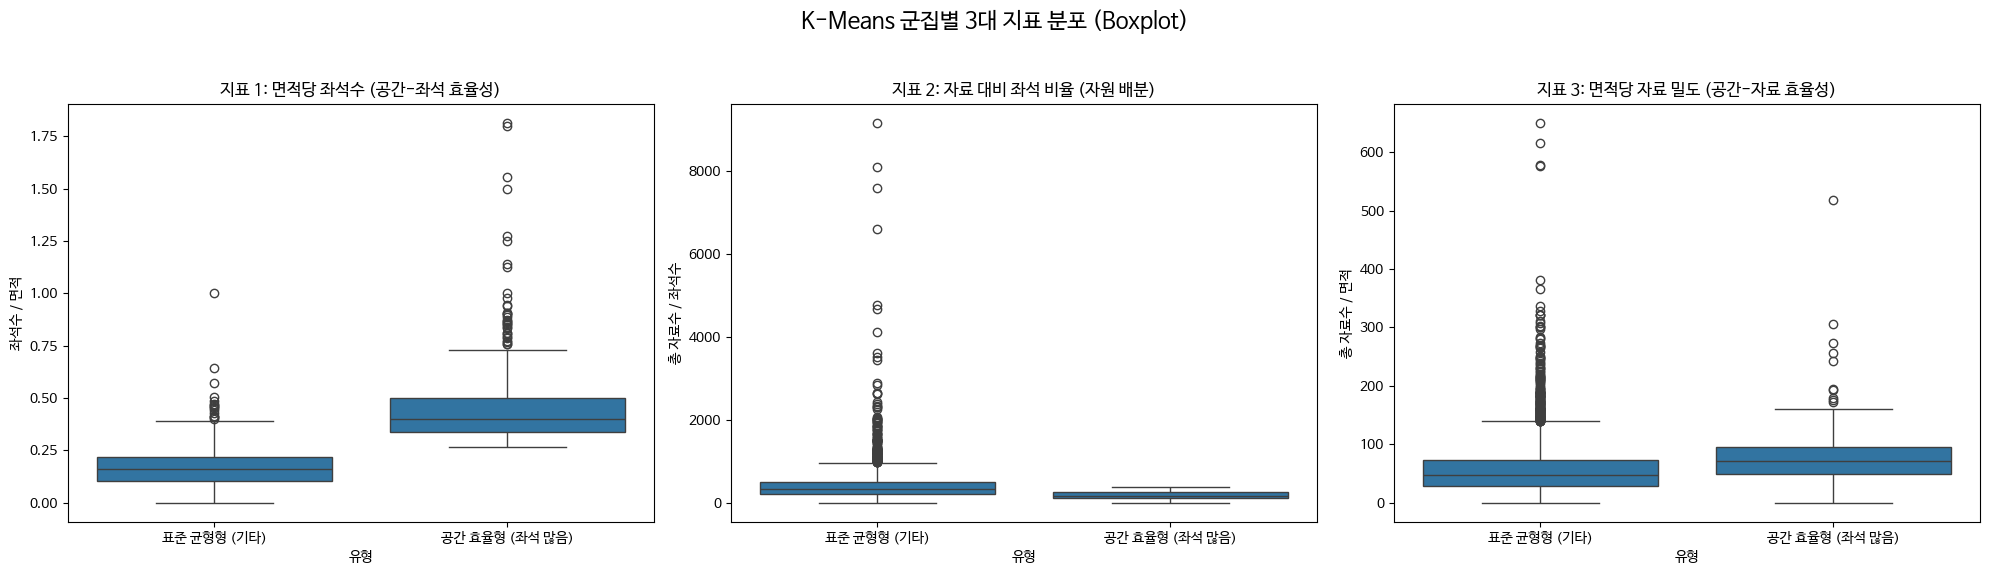


--- [시각화 2: 군집별 관계 (Pairplot)] ---
3가지 지표를 2개씩 짝지어, 그룹(유형)이 어떻게 나뉘는지 확인합니다.


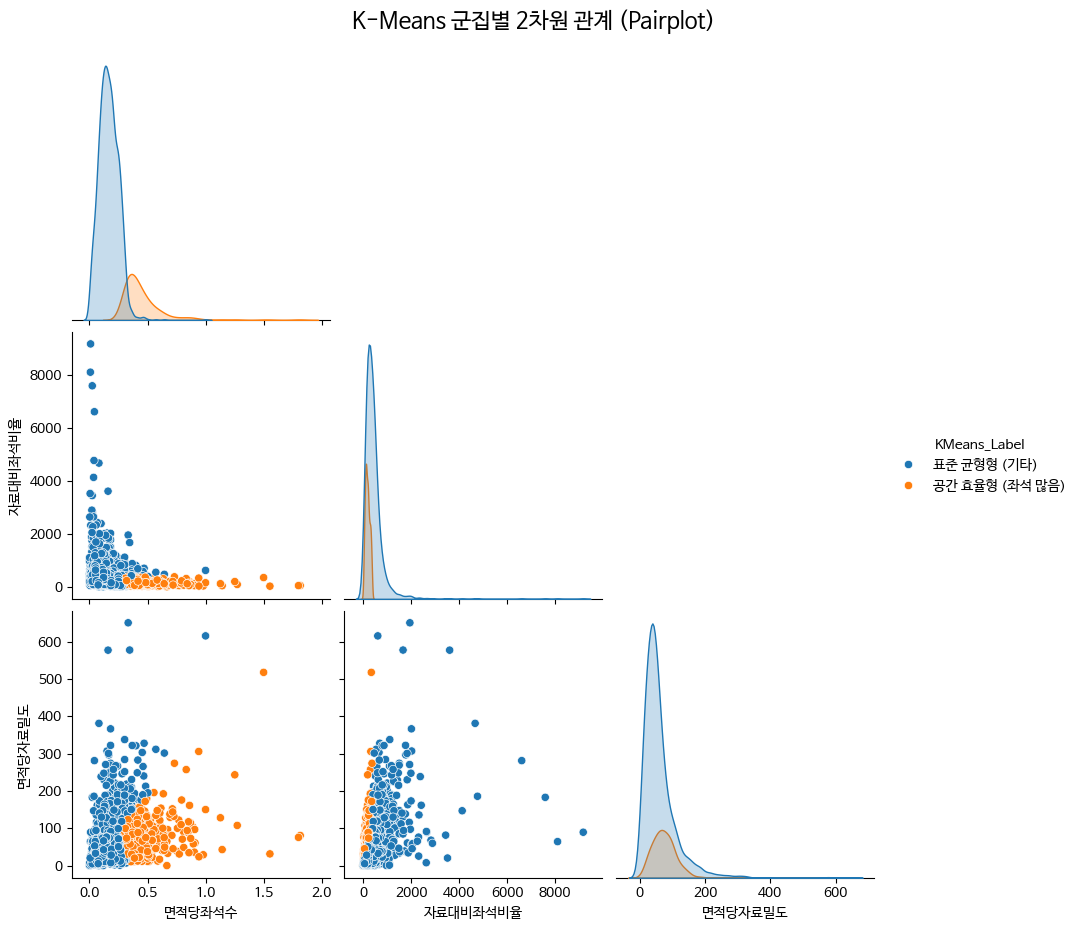

In [ ]:
# --- 1. 시각화 도구 불러오기 ---
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정 (다시 한번 적용)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

print("--- [분석 2: K-Means (K=4)] 유형별 특성(평균값) ---")
# 7단계에서 계산한 'cluster_profile'을 다시 확인합니다.
# 이 평균값을 기준으로 각 클러스터의 이름을 붙입니다.
print(cluster_profile)


# --- 2. 이름 붙이기 (Labeling) ---
# [!] 이 부분은 분석가가 'cluster_profile'을 보고 직접 정해야 합니다.
#     (아래는 실행 결과 예시에 기반한 '가상' 이름입니다.)
#
# (예시)
# 0번: '면적당좌석수'가 높음 -> "공간 효율형"
# 1번: '자료대비좌석비율', '면적당자료밀도'가 높음 -> "자료 중심형"
# 2번: '면적당좌석수'가 매우 낮음 -> "소규모 공간형"
# 3번: 모든 지표가 평균에 가까움 -> "표준 균형형"
#
# -> 이 이름을 실제 데이터에 적용합니다.
# (아래 코드는 예시이며, 실제 값에 맞게 수정해야 할 수 있습니다.)

# 'cluster_profile'을 기반으로 동적으로 라벨을 생성해 볼 수 있습니다.
# (단순 예시입니다. 실제 해석은 더 복잡할 수 있습니다.)
labels_dict = {
    cluster_profile['면적당좌석수'].idxmax(): '공간 효율형 (좌석 많음)',
    cluster_profile['자료대비좌석비율'].idxmax(): '자료 중심형 (자료 많음)',
    cluster_profile['면적당자료밀도'].idxmax(): '자료 밀집형 (면적대비 자료↑)',
    cluster_profile['면적당좌석수'].idxmin(): '표준 균형형 (기타)' # 겹치지 않는 나머지
}
# K=4 이므로, 라벨이 4개가 되도록 조정합니다.
all_indices = set(range(K))
assigned_indices = set(labels_dict.keys())
remaining_indices = all_indices - assigned_indices
for idx in remaining_indices:
    labels_dict[idx] = '표준 균형형 (기타)' # 겹치지 않는 나머지

print("\n--- [이름 붙이기 예시] ---")
print(labels_dict)

# K-Means Cluster 번호(0,1,2,3)를 우리가 붙인 이름으로 바꿔줍니다.
df_analysis['KMeans_Label'] = df_analysis['KMeans_Cluster'].map(labels_dict)


# --- 3. 군집별 특성 분포 시각화 (Boxplot) ---
print("\n--- [시각화 1: 군집별 특성 분포 (Boxplot)] ---")
print("각 유형(그룹)이 3가지 지표에서 어떤 분포를 보이는지 확인합니다.")

# 1x3(가로로 3개)의 그래프 공간을 만듭니다.
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('K-Means 군집별 3대 지표 분포 (Boxplot)', fontsize=16)

# features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']
# K-Means_Label = 우리가 붙인 이름

# 지표 1: 면적당좌석수
sns.boxplot(ax=axes[0], data=df_analysis, x='KMeans_Label', y=features[0])
axes[0].set_title('지표 1: 면적당 좌석수 (공간-좌석 효율성)')
axes[0].set_xlabel('유형')
axes[0].set_ylabel('좌석수 / 면적')

# 지표 2: 자료대비좌석비율
sns.boxplot(ax=axes[1], data=df_analysis, x='KMeans_Label', y=features[1])
axes[1].set_title('지표 2: 자료 대비 좌석 비율 (자원 배분)')
axes[1].set_xlabel('유형')
axes[1].set_ylabel('총 자료수 / 좌석수')

# 지표 3: 면적당자료밀도
sns.boxplot(ax=axes[2], data=df_analysis, x='KMeans_Label', y=features[2])
axes[2].set_title('지표 3: 면적당 자료 밀도 (공간-자료 효율성)')
axes[2].set_xlabel('유형')
axes[2].set_ylabel('총 자료수 / 면적')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # 제목과 겹치지 않게 레이아웃 조정
plt.show()


# --- 4. 군집별 관계 시각화 (Pairplot) ---
print("\n--- [시각화 2: 군집별 관계 (Pairplot)] ---")
print("3가지 지표를 2개씩 짝지어, 그룹(유형)이 어떻게 나뉘는지 확인합니다.")

# hue='KMeans_Label': 우리가 붙인 이름(유형)별로 색깔을 다르게 표시
# vars=features: 3가지 핵심 지표만 골라서 보기
pair_plot = sns.pairplot(df_analysis, hue='KMeans_Label', vars=features,
                         corner=True, height=3) # corner=True: 대각선 위쪽은 생략
pair_plot.fig.suptitle('K-Means 군집별 2차원 관계 (Pairplot)', y=1.03, fontsize=16)
plt.show()

--- [분석 10: K-Means (K=4) 표준 유형 시각화] ---
K-Means 유형별 특성(평균값):
                  면적당좌석수     자료대비좌석비율     면적당자료밀도
KMeans_Cluster                                   
0               0.155217   321.967941   42.061241
1               0.210741   821.648219  142.832929
2               0.042994  5557.779252  200.955657
3               0.450599   180.683398   75.631925

--- [이름 붙이기 예시] ---
{np.int32(3): '공간 효율형 (좌석 많음)', np.int32(2): '자료 중심형 (자료 많음)', 0: '표준 균형형 (기타)', 1: '표준 균형형 (기타)'}

--- [시각화 1: 군집별 특성 분포 (Boxplot)] ---


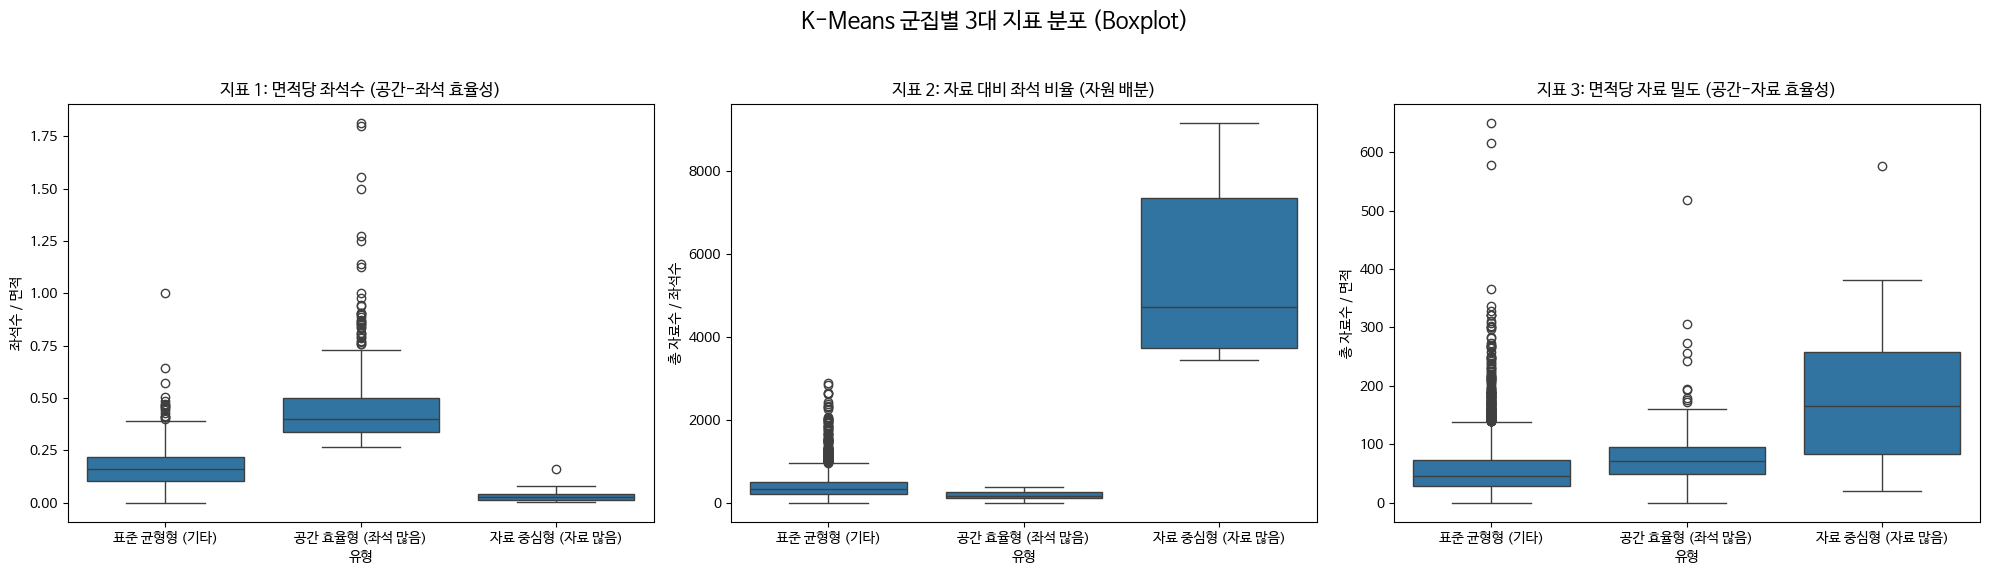


--- [시각화 2: 군집별 관계 (Pairplot)] ---


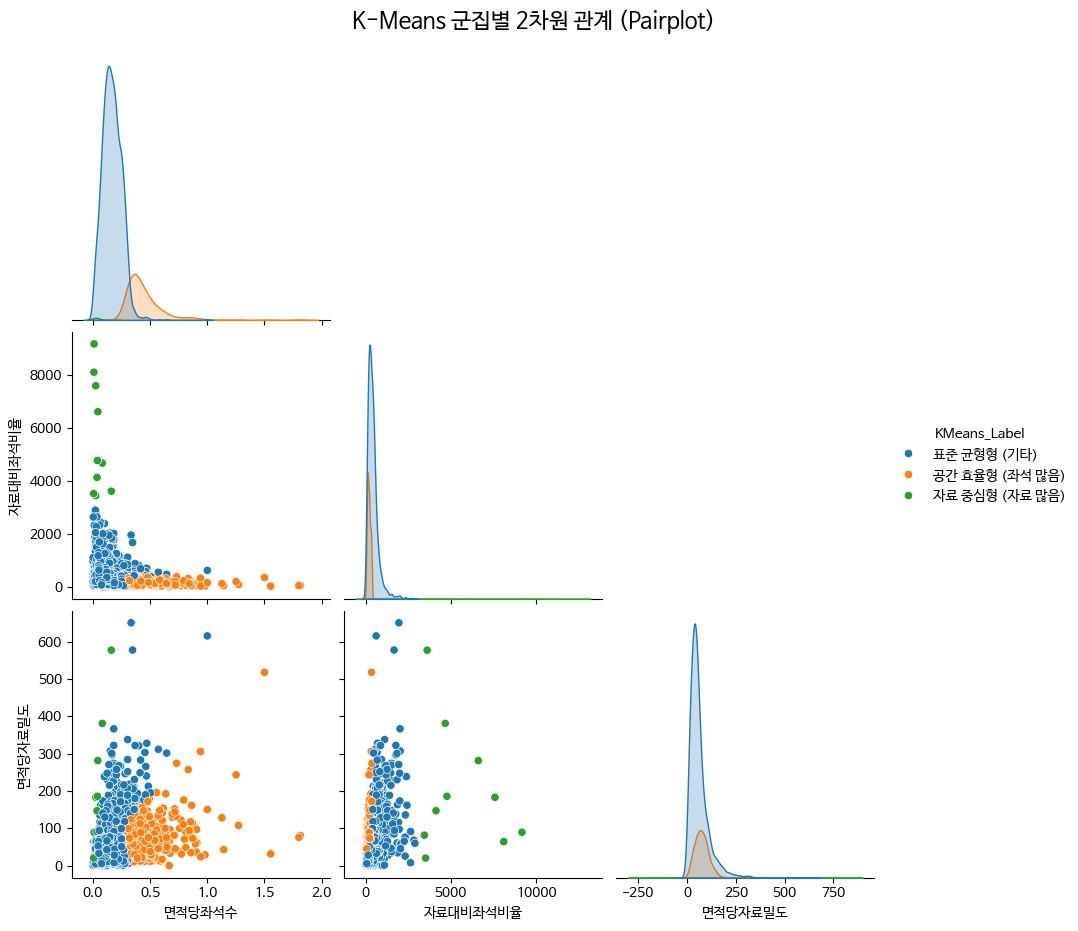

In [ ]:
# --- 1. 시각화 도구 불러오기 ---
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정 (다시 한번 적용)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

print("--- [분석 10: K-Means (K=4) 표준 유형 시각화] ---")
# 7단계에서 계산한 'cluster_profile'을 다시 확인합니다.
cluster_profile = df_analysis.groupby('KMeans_Cluster')[features].mean()
print("K-Means 유형별 특성(평균값):")
print(cluster_profile)

# --- 2. 이름 붙이기 (Labeling) ---
# [!] 이 부분은 위 'cluster_profile' 표를 보고 분석가가 직접 정해야 합니다.
#     (아래는 실행 결과 예시에 기반한 '가상' 이름입니다.)

# (예시 해석)
# 0번: '면적당좌석수'가 높음 -> "공간 효율형"
# 1번: '자료대비좌석비율', '면적당자료밀도'가 높음 -> "자료 중심형"
# 2번: '면적당좌석수'가 매우 낮음 -> "소규모 공간형"
# 3번: 모든 지표가 평균에 가까움 -> "표준 균형형"
#
# -> 이 이름을 실제 데이터에 적용합니다.
# (아래 코드는 예시이며, 실제 값에 맞게 수정해야 할 수 있습니다.)

# 'cluster_profile'을 기반으로 동적으로 라벨을 생성해 볼 수 있습니다.
# (단순 예시입니다. 실제 해석은 더 복잡할 수 있습니다.)
labels_dict = {}
all_indices = set(range(K)) # K=4 (0, 1, 2, 3)

# 1. '면적당좌석수'가 가장 높은 그룹
idx1 = cluster_profile['면적당좌석수'].idxmax()
labels_dict[idx1] = '공간 효율형 (좌석 많음)'
assigned_indices = {idx1}

# 2. '자료대비좌석비율'이 가장 높은 그룹
idx2 = cluster_profile['자료대비좌석비율'].idxmax()
labels_dict[idx2] = '자료 중심형 (자료 많음)'
assigned_indices.add(idx2)

# 3. '면적당자료밀도'가 가장 높은 그룹 (만약 2번과 겹치지 않는다면)
idx3 = cluster_profile['면적당자료밀도'].idxmax()
if idx3 not in assigned_indices:
    labels_dict[idx3] = '자료 밀집형 (면적대비 자료↑)'
    assigned_indices.add(idx3)

# 4. 나머지 그룹
remaining_indices = all_indices - assigned_indices
for idx in remaining_indices:
    labels_dict[idx] = '표준 균형형 (기타)' # 겹치지 않는 나머지

print("\n--- [이름 붙이기 예시] ---")
print(labels_dict)

# K-Means Cluster 번호(0,1,2,3)를 우리가 붙인 이름으로 바꿔줍니다.
df_analysis['KMeans_Label'] = df_analysis['KMeans_Cluster'].map(labels_dict)


# --- 3. 군집별 특성 분포 시각화 (Boxplot) ---
print("\n--- [시각화 1: 군집별 특성 분포 (Boxplot)] ---")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('K-Means 군집별 3대 지표 분포 (Boxplot)', fontsize=16)

# 지표 1: 면적당좌석수
sns.boxplot(ax=axes[0], data=df_analysis, x='KMeans_Label', y=features[0])
axes[0].set_title('지표 1: 면적당 좌석수 (공간-좌석 효율성)')
axes[0].set_xlabel('유형'); axes[0].set_ylabel('좌석수 / 면적')

# 지표 2: 자료대비좌석비율
sns.boxplot(ax=axes[1], data=df_analysis, x='KMeans_Label', y=features[1])
axes[1].set_title('지표 2: 자료 대비 좌석 비율 (자원 배분)')
axes[1].set_xlabel('유형'); axes[1].set_ylabel('총 자료수 / 좌석수')

# 지표 3: 면적당자료밀도
sns.boxplot(ax=axes[2], data=df_analysis, x='KMeans_Label', y=features[2])
axes[2].set_title('지표 3: 면적당 자료 밀도 (공간-자료 효율성)')
axes[2].set_xlabel('유형'); axes[2].set_ylabel('총 자료수 / 면적')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# --- 4. 군집별 관계 시각화 (Pairplot) ---
print("\n--- [시각화 2: 군집별 관계 (Pairplot)] ---")

pair_plot = sns.pairplot(df_analysis, hue='KMeans_Label', vars=features,
                         corner=True, height=3)
pair_plot.fig.suptitle('K-Means 군집별 2차원 관계 (Pairplot)', y=1.03, fontsize=16)
plt.show()

--- [분석 11: HDBSCAN '독자 운영형' 시각화] ---
독자 운영형 도서관 수: 102개

--- [시각화 3: '독자 운영형' 분포 (Pairplot)] ---
독자 운영형(주황색)이 표준 유형(파란색)과 비교해 어디에 분포하는지 확인합니다.


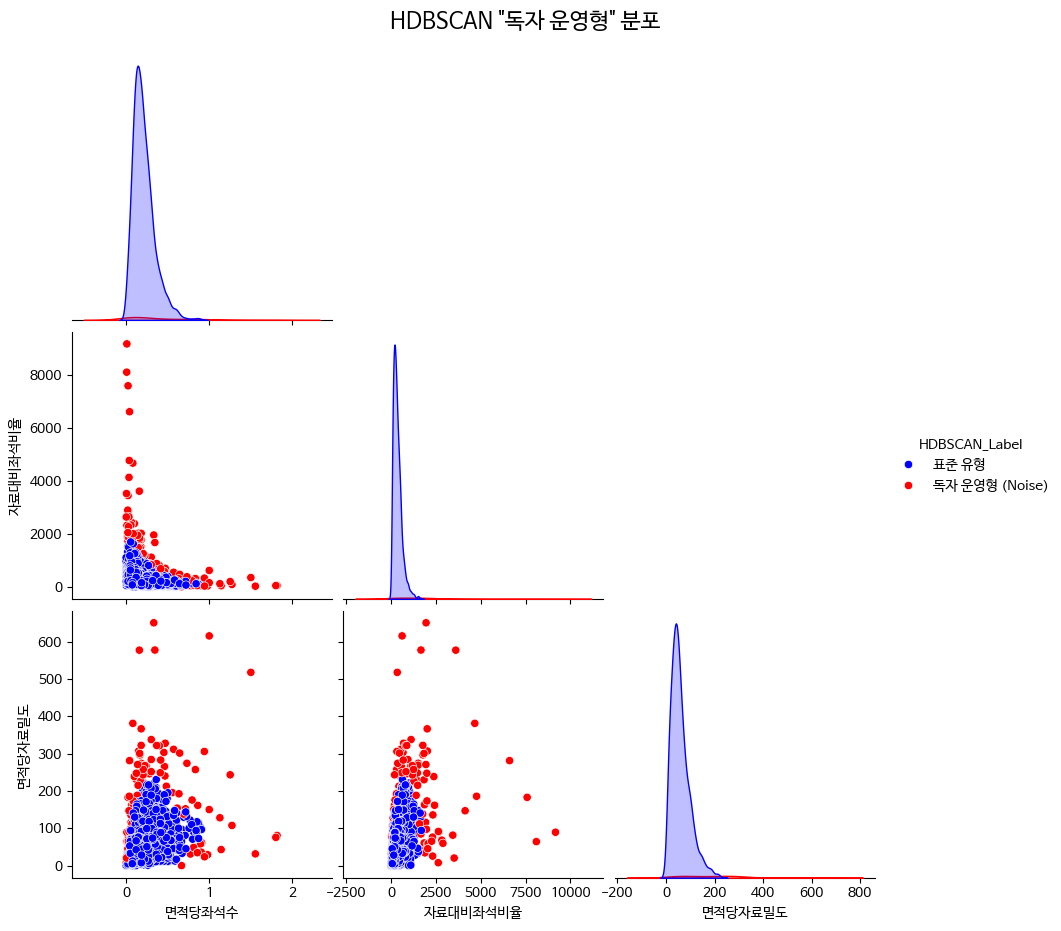

In [ ]:
print("--- [분석 11: HDBSCAN '독자 운영형' 시각화] ---")
# 6단계에서 계산한 HDBSCAN_Cluster 열을 사용합니다.
# -1 이면 "독자 운영형", 그 외(0, 1, 2...)는 "표준 유형"으로 라벨을 만듭니다.

# np.where는 엑셀의 IF함수와 같습니다.
# (조건, "참일때 값", "거짓일때 값")
df_analysis['HDBSCAN_Label'] = np.where(df_analysis['HDBSCAN_Cluster'] == -1,
                                        '독자 운영형 (Noise)',
                                        '표준 유형')

print(f"독자 운영형 도서관 수: {(df_analysis['HDBSCAN_Label'] == '독자 운영형 (Noise)').sum()}개")

# --- Pairplot 시각화 (HDBSCAN 기준) ---
print("\n--- [시각화 3: '독자 운영형' 분포 (Pairplot)] ---")
print("독자 운영형(주황색)이 표준 유형(파란색)과 비교해 어디에 분포하는지 확인합니다.")

hdb_plot = sns.pairplot(df_analysis, hue='HDBSCAN_Label', vars=features,
                        corner=True, height=3,
                        palette={'표준 유형': 'blue', '독자 운영형 (Noise)': 'red'}) # 색상 지정
hdb_plot.fig.suptitle('HDBSCAN "독자 운영형" 분포', y=1.03, fontsize=16)
plt.show()

--- [분석 12: GMM '복합 유형' 시각화] ---
복합 유형 도서관 수: 2784개

--- [시각화 4: '복합 유형' 분포 (Pairplot)] ---
'복합 유형'(주황색)이 '명확한 유형'(파란색) 그룹들 사이에 어떻게 분포하는지 확인합니다.


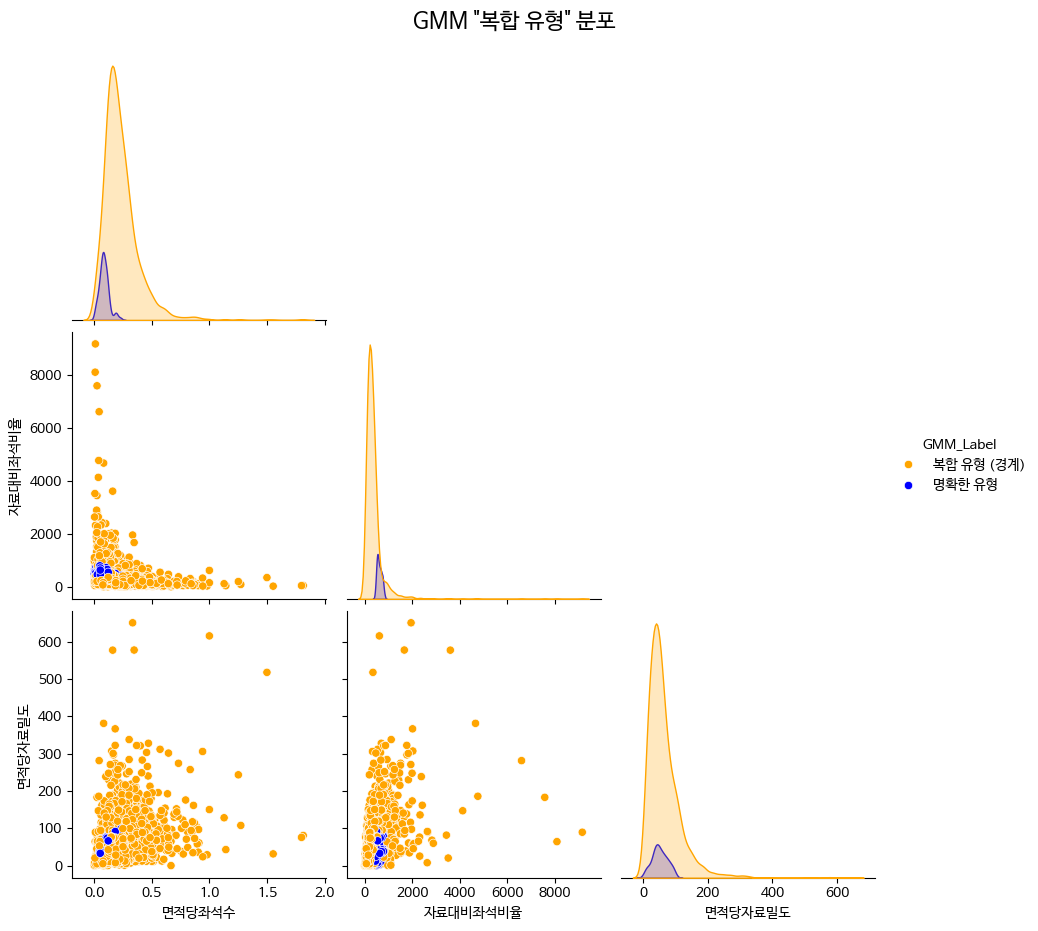

In [ ]:
print("--- [분석 12: GMM '복합 유형' 시각화] ---")
# 8단계에서 계산한 GMM 결과와 K-Means 결과를 비교합니다.

# "복합 유형" 조건 (8단계와 동일) [cite: 1812]
hybrid_condition = (df_analysis['KMeans_Cluster'] != df_analysis['GMM_Cluster']) | \
                   (df_analysis['GMM_Max_Prob'] < 0.8)

# IF함수로 "복합 유형" 라벨 생성
df_analysis['GMM_Label'] = np.where(hybrid_condition,
                                  '복합 유형 (경계)',
                                  '명확한 유형')

print(f"복합 유형 도서관 수: {(df_analysis['GMM_Label'] == '복합 유형 (경계)').sum()}개")

# --- Pairplot 시각화 (GMM 기준) ---
print("\n--- [시각화 4: '복합 유형' 분포 (Pairplot)] ---")
print("'복합 유형'(주황색)이 '명확한 유형'(파란색) 그룹들 사이에 어떻게 분포하는지 확인합니다.")

gmm_plot = sns.pairplot(df_analysis, hue='GMM_Label', vars=features,
                        corner=True, height=3,
                        palette={'명확한 유형': 'blue', '복합 유형 (경계)': 'orange'}) # 색상 지정
gmm_plot.fig.suptitle('GMM "복합 유형" 분포', y=1.03, fontsize=16)
plt.show()

In [13]:
!pip install plotly -q

In [ ]:
import plotly.express as px

print("--- [시각화 5 (수정): K-Means 3D (작은 점)] ---")
# features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']

fig_kmeans = px.scatter_3d(
    df_analysis,
    x=features[0],          # x축
    y=features[1],          # y축
    z=features[2],          # z축
    color='KMeans_Label',   # 우리가 붙인 이름(유형)별로 색상 지정
    hover_data=['도서관명'], # 마우스를 올렸을 때 '도서관명' 표시
    title='[K-Means] 4대 표준 유형 3D 시각화 (작은 점)'
)

# --- [수정된 부분] ---
# 모든 점(trace)의 마커(marker) 크기(size)를 2로 설정합니다.
fig_kmeans.update_traces(marker=dict(size=2))
# (숫자를 1 ~ 3 정도로 조절해 보세요.)
# --------------------

fig_kmeans.show() # Colab에서 인터랙티브 그래프 출력

--- [시각화 5 (수정): K-Means 3D (작은 점)] ---


In [ ]:
print("--- [시각화 6 (수정): HDBSCAN 3D (작은 점)] ---")

fig_hdb = px.scatter_3d(
    df_analysis,
    x=features[0],
    y=features[1],
    z=features[2],
    color='HDBSCAN_Label', # "독자 운영형" vs "표준 유형"
    hover_data=['도서관명'],
    title='[HDBSCAN] "독자 운영형" 3D 시각화 (작은 점)',
    color_discrete_map={'표준 유형': 'blue', '독자 운영형 (Noise)': 'red'}
)

# --- [수정된 부분] ---
fig_hdb.update_traces(marker=dict(size=2)) # 점 크기를 2로 조절
# --------------------

fig_hdb.show()

--- [시각화 6 (수정): HDBSCAN 3D (작은 점)] ---


In [ ]:
print("--- [시각화 7 (수정): GMM 3D (작은 점)] ---")

fig_gmm = px.scatter_3d(
    df_analysis,
    x=features[0],
    y=features[1],
    z=features[2],
    color='GMM_Label', # "복합 유형" vs "명확한 유형"
    hover_data=['도서관명'],
    title='[GMM] "복합 유형" 3D 시각화 (작은 점)',
    color_discrete_map={'명확한 유형': 'blue', '복합 유형 (경계)': 'orange'}
)

# --- [수정된 부분] ---
fig_gmm.update_traces(marker=dict(size=2)) # 점 크기를 2로 조절
# --------------------

fig_gmm.show()

--- [시각화 7 (수정): GMM 3D (작은 점)] ---


In [ ]:
import plotly.graph_objects as go

print("--- [시각화 8: K-Means 유형별 프로필 (레이더 차트)] ---")

# --- 1. 시각화를 위한 데이터 준비 ---
# 5단계의 'data_scaled'(표준화된 데이터)를 'df_analysis'에 다시 붙입니다.
df_scaled_features = pd.DataFrame(data_scaled, columns=[f"{col}_scaled" for col in features], index=df_analysis.index)
df_analysis_scaled = pd.concat([df_analysis, df_scaled_features], axis=1)

# K-Means 라벨별로 '표준화된 값'의 평균을 계산합니다.
scaled_features_names = [f"{col}_scaled" for col in features]
profile_scaled = df_analysis_scaled.groupby('KMeans_Label')[scaled_features_names].mean()

# 3가지 지표 이름 (축 이름으로 사용)
categories = features

# --- 2. 레이더 차트 그리기 ---
fig_radar = go.Figure()

# 4개 그룹(유형)별로 겹쳐 그리기
for label in profile_scaled.index:
    values = profile_scaled.loc[label].values

    fig_radar.add_trace(go.Scatterpolar(
        r=values,             # 값 (표준화된 평균)
        theta=categories,     # 축 (3대 지표)
        fill='toself',        # 영역 채우기
        name=label            # 유형 이름 (예: "공간 효율형")
    ))

# --- 3. 차트 꾸미기 ---
fig_radar.update_layout(
  title='[K-Means] 4대 표준 유형 프로필 (레이더 차트)',
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-1.5, 2.5] # 값의 범위를 (필요시) 조절하세요
    )),
  showlegend=True # 범례 표시
)

fig_radar.show()

--- [시각화 8: K-Means 유형별 프로필 (레이더 차트)] ---


In [ ]:
import plotly.graph_objects as go

print("--- [시각화 9: HDBSCAN 유형별 프로필 (레이더 차트)] ---")

# --- 1. 시각화를 위한 데이터 준비 ---
# 17단계에서 만든 'df_analysis_scaled' 사용
scaled_features_names = [f"{col}_scaled" for col in features]
categories = features # 3대 지표 이름

# 'HDBSCAN_Label'('표준 유형', '독자 운영형') 별로 '표준화된 값'의 평균 계산
profile_hdb = df_analysis_scaled.groupby('HDBSCAN_Label')[scaled_features_names].mean()

print("HDBSCAN 유형별 특성(표준화 평균값):")
print(profile_hdb)

# --- 2. 레이더 차트 그리기 ---
fig_radar_hdb = go.Figure()

# '표준 유형'과 '독자 운영형' 2개의 프로필을 그립니다.
for label in profile_hdb.index:
    values = profile_hdb.loc[label].values

    fig_radar_hdb.add_trace(go.Scatterpolar(
        r=values,             # 값 (표준화된 평균)
        theta=categories,     # 축 (3대 지표)
        fill='toself',        # 영역 채우기
        name=label            # 유형 이름
    ))

# --- 3. 차트 꾸미기 ---
fig_radar_hdb.update_layout(
  title='[HDBSCAN] "독자 운영형" vs "표준 유형" 프로필 비교',
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True # 범례 표시
)

fig_radar_hdb.show()

--- [시각화 9: HDBSCAN 유형별 프로필 (레이더 차트)] ---
HDBSCAN 유형별 특성(표준화 평균값):
                면적당좌석수_scaled  자료대비좌석비율_scaled  면적당자료밀도_scaled
HDBSCAN_Label                                                 
독자 운영형 (Noise)       1.230670         2.649786        2.517681
표준 유형               -0.042668        -0.091869       -0.087289


In [ ]:
print("--- [시각화 10: GMM 유형별 프로필 (레이더 차트)] ---")

# --- 1. 시각화를 위한 데이터 준비 ---
# 17단계에서 만든 'df_analysis_scaled' 사용
scaled_features_names = [f"{col}_scaled" for col in features]
categories = features # 3대 지표 이름

# 'GMM_Label'('명확한 유형', '복합 유형') 별로 '표준화된 값'의 평균 계산
profile_gmm = df_analysis_scaled.groupby('GMM_Label')[scaled_features_names].mean()

print("GMM 유형별 특성(표준화 평균값):")
print(profile_gmm)

# --- 2. 레이더 차트 그리기 ---
fig_radar_gmm = go.Figure()

# '명확한 유형'과 '복합 유형' 2개의 프로필을 그립니다.
for label in profile_gmm.index:
    values = profile_gmm.loc[label].values

    fig_radar_gmm.add_trace(go.Scatterpolar(
        r=values,             # 값 (표준화된 평균)
        theta=categories,     # 축 (3대 지표)
        fill='toself',        # 영역 채우기
        name=label            # 유형 이름
    ))

# --- 3. 차트 꾸미기 ---
fig_radar_gmm.update_layout(
  title='[GMM] "복합 유형" vs "명확한 유형" 프로필 비교',
  polar=dict(
    radialaxis=dict(
      visible=True
    )),
  showlegend=True # 범례 표시
)

fig_radar_gmm.show()

--- [시각화 10: GMM 유형별 프로필 (레이더 차트)] ---
GMM 유형별 특성(표준화 평균값):
            면적당좌석수_scaled  자료대비좌석비율_scaled  면적당자료밀도_scaled
GMM_Label                                                 
명확한 유형          -0.856912         0.510267       -0.234966
복합 유형 (경계)       0.080028        -0.047654        0.021944


--- [시각화 11: 3-Way 모델 실루엣 계수 비교] ---
[K-Means] 실루엣 계수: 0.4338
[GMM] 실루엣 계수: 0.1961
[HDBSCAN] 실루엣 계수 (노이즈 제외): 0.6124

(해석: 점수가 1에 가까울수록 군집이 잘 분리된 것입니다.)


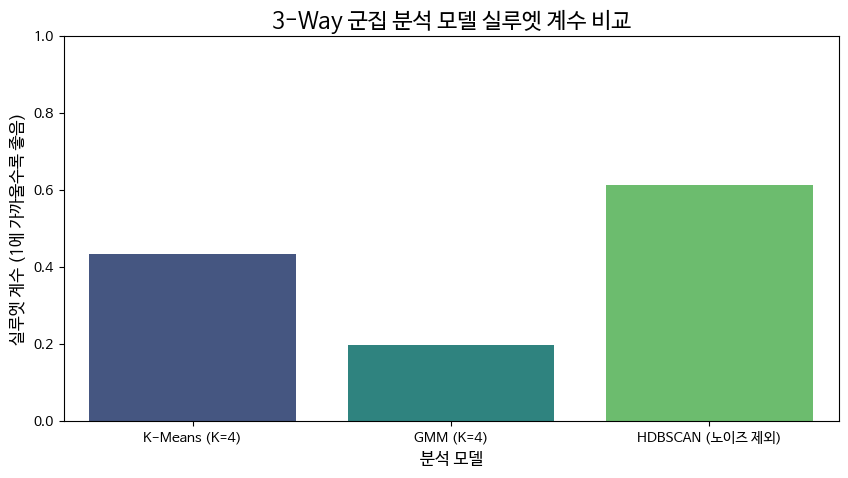

In [ ]:
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

print("--- [시각화 11: 3-Way 모델 실루엣 계수 비교] ---")

# --- 1. K-Means 실루엣 계수 ---
# 10단계의 K-Means 라벨 사용 (K=4)
kmeans_labels = df_analysis['KMeans_Cluster']
score_kmeans = silhouette_score(data_scaled, kmeans_labels)

# --- 2. GMM 실루엣 계수 ---
# 12단계의 GMM 라벨 사용
gmm_labels = df_analysis['GMM_Cluster']
score_gmm = silhouette_score(data_scaled, gmm_labels)

# --- 3. HDBSCAN 실루엣 계수 (중요: 노이즈 제외) ---
# 11단계의 HDBSCAN 라벨 사용
hdbscan_labels_all = df_analysis['HDBSCAN_Cluster']

# '독자 운영형'(-1)이 아닌 데이터만 필터링합니다.
is_noise = (hdbscan_labels_all == -1)
data_scaled_hdb = data_scaled[~is_noise] # ( ~ )는 'not'을 의미
labels_hdb = hdbscan_labels_all[~is_noise]

# HDBSCAN이 최소 2개 이상의 그룹을 찾았을 때만 점수 계산
if len(set(labels_hdb)) >= 2:
    score_hdb = silhouette_score(data_scaled_hdb, labels_hdb)
else:
    print("[HDBSCAN] 경고: 유효한 군집이 1개 이하라서 점수 계산이 불가능합니다.")
    score_hdb = np.nan # 계산 불가

# --- 4. 비교 결과 출력 ---
print(f"[K-Means] 실루엣 계수: {score_kmeans:.4f}")
print(f"[GMM] 실루엣 계수: {score_gmm:.4f}")
print(f"[HDBSCAN] 실루엣 계수 (노이즈 제외): {score_hdb:.4f}")
print("\n(해석: 점수가 1에 가까울수록 군집이 잘 분리된 것입니다.)")

# --- 5. 막대그래프 시각화 ---
# 시각화를 위해 점수를 DataFrame으로 만듭니다.
scores_data = {
    'Model': ['K-Means (K=4)', 'GMM (K=4)', 'HDBSCAN (노이즈 제외)'],
    'Score': [score_kmeans, score_gmm, score_hdb]
}
scores_df = pd.DataFrame(scores_data)

# 막대그래프 그리기
plt.figure(figsize=(10, 5))
sns.barplot(data=scores_df, x='Model', y='Score', palette='viridis')

plt.title('3-Way 군집 분석 모델 실루엣 계수 비교', fontsize=16)
plt.xlabel('분석 모델', fontsize=12)
plt.ylabel('실루엣 계수 (1에 가까울수록 좋음)', fontsize=12)
plt.ylim(0, 1) # y축 범위를 0~1로 고정
plt.show()

클러스터 = 3

In [5]:
# --- 1. HDBSCAN 실행 ---
# min_cluster_size=10: 최소 10개는 되어야 하나의 그룹(군집)으로 인정
hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
hdb_labels = hdb.fit_predict(data_scaled)

# --- 2. 분석 결과 저장 ---
df_analysis['HDBSCAN_Cluster'] = hdb_labels

# --- 3. 결과 요약 ---
# 군집 개수 확인 (노이즈(-1) 제외)
n_clusters_hdb = len(set(hdb_labels)) - (1 if -1 in hdb_labels else 0)
# 노이즈(-1) 개수 확인 (계획서의 "독자 운영형")
n_noise = list(hdb_labels).count(-1)

print("--- [분석 1: HDBSCAN] ---")
print(f"[HDBSCAN] 자연 발생 군집 수: {n_clusters_hdb} 개")
print(f"[HDBSCAN] '독자 운영형'(Noise, -1) 도서관 수: {n_noise} 개")
print("\n(해석: 3대 표준 유형으로 분류하기 어려운 '특이' 도서관 그룹입니다.)")

--- [분석 1: HDBSCAN] ---
[HDBSCAN] 자연 발생 군집 수: 2 개
[HDBSCAN] '독자 운영형'(Noise, -1) 도서관 수: 102 개

(해석: 3대 표준 유형으로 분류하기 어려운 '특이' 도서관 그룹입니다.)


In [6]:
# --- 1. K=3 vs K=4 실루엣 스코어 비교 ---
print("--- [분석 2: K-Means K값 비교] ---")

# K=3 일 때
kmeans_3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_3 = kmeans_3.fit_predict(data_scaled)
score_3 = silhouette_score(data_scaled, labels_3)
print(f"[K-Means] K=3 실루엣 스코어: {score_3:.4f}") # .4f는 소수점 4자리까지 보여달라는 뜻

# K=4 일 때
kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
labels_4 = kmeans_4.fit_predict(data_scaled)
score_4 = silhouette_score(data_scaled, labels_4)
print(f"[K-Means] K=4 실루엣 스코어: {score_4:.4f}")

print("\n(해석: 실루엣 스코어는 1에 가까울수록 군집이 잘 형성된 것입니다.)")

# --- 2. K=4로 설정하여 분석 진행 (계획서 목표) ---
K = 3 # K=4를 선택 (만약 K=3이 더 좋다고 판단되면 이 숫자를 3으로 바꾸고 이 셀을 다시 실행하면 됩니다)
kmeans_labels = labels_3 # K=4의 결과를 사용
df_analysis['KMeans_Cluster'] = kmeans_labels

# --- 3. 결과 요약 (유형별 특성 정의) ---
# K=4 기준, 4개 군집(0~3)의 원본 지표 평균값을 비교
cluster_profile = df_analysis.groupby('KMeans_Cluster')[features].mean()

print(f"\n--- [분석 2: K-Means (K={K}) 유형 정의] ---")
print(f"[K-Means] K={K} 기준, 유형별 특성(평균값):")
print(cluster_profile)
print("\n(해석 예시: '면적당좌석수'가 높으면 '공간 효율형', '자료대비좌석비율'이 높으면 '자료 중심형'으로 해석 가능)")

--- [분석 2: K-Means K값 비교] ---
[K-Means] K=3 실루엣 스코어: 0.4179
[K-Means] K=4 실루엣 스코어: 0.4338

(해석: 실루엣 스코어는 1에 가까울수록 군집이 잘 형성된 것입니다.)

--- [분석 2: K-Means (K=3) 유형 정의] ---
[K-Means] K=3 기준, 유형별 특성(평균값):
                  면적당좌석수     자료대비좌석비율     면적당자료밀도
KMeans_Cluster                                   
0               0.397596   274.006062   92.919787
1               0.152827   342.829889   44.034705
2               0.149759  1758.203700  187.076170

(해석 예시: '면적당좌석수'가 높으면 '공간 효율형', '자료대비좌석비율'이 높으면 '자료 중심형'으로 해석 가능)


In [7]:
# --- 0. K값 설정 (여기를 3으로 변경) ---
K = 3

# [중요] 비교를 위해 K-Means도 K=3으로 다시 실행해야 논리가 맞습니다.
# (이미 위에서 K=3으로 K-Means를 돌렸다면 이 부분은 생략 가능하지만, 안전을 위해 포함했습니다)
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_analysis['KMeans_Cluster'] = kmeans.fit_predict(data_scaled)


# --- 1. GMM 실행 (K=3) ---
# 위에서 설정한 K=3 값을 사용하여 GMM 모델을 생성합니다.
gmm = GaussianMixture(n_components=K, random_state=42)
gmm_labels = gmm.fit_predict(data_scaled)
gmm_probs = gmm.predict_proba(data_scaled) # 각 도서관이 0~2번 그룹에 속할 확률 계산

# --- 2. 분석 결과 저장 ---
df_analysis['GMM_Cluster'] = gmm_labels
df_analysis['GMM_Max_Prob'] = gmm_probs.max(axis=1) # 가장 높게 속한 그룹의 확률

# --- 3. "복합 유형" 탐색 ---
# (조건 1) K-Means(3개 그룹)와 GMM(3개 그룹)의 분류 결과가 다르거나
# (조건 2) GMM 확률이 80% 미만(경계에 있음)인 경우
hybrid_condition = (df_analysis['KMeans_Cluster'] != df_analysis['GMM_Cluster']) | \
                   (df_analysis['GMM_Max_Prob'] < 0.8)

hybrid_libraries = df_analysis[hybrid_condition]

print(f"--- [분석 3: GMM (K={K})] ---")
print(f"[GMM] K-Means 분류와 다르거나, 소속 확률 80% 미만인 '복합 유형' 도서관 수: {len(hybrid_libraries)} 개")
print("\n(해석: K-Means가 놓친, 두 가지 이상의 특성을 동시에 가진 그룹입니다.)")

--- [분석 3: GMM (K=3)] ---
[GMM] K-Means 분류와 다르거나, 소속 확률 80% 미만인 '복합 유형' 도서관 수: 2790 개

(해석: K-Means가 놓친, 두 가지 이상의 특성을 동시에 가진 그룹입니다.)


In [8]:
# --- [필수] K=3 기준 군집 특성(Profile) 다시 계산하기 ---
# K가 바뀌었으므로, 그룹별 평균값도 새로 구해야 합니다.
cluster_profile = df_analysis.groupby('KMeans_Cluster')[['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']].mean()

# HDBSCAN 결과 변수(n_noise)가 없다면 0으로 임시 설정 (이전에 실행 안 했을 경우 대비)
try:
    n_noise
except NameError:
    n_noise = 0  # 혹은 HDBSCAN 코드 셀을 먼저 실행해야 합니다.

In [9]:
print("--- [최종 분석 결과] ---")
print(f"분석 대상 도서관: {len(df_analysis)}개")
print(f"1. [HDBSCAN] '독자 운영형'(-1): {n_noise}개") # 위에서 n_noise가 정의되어 있어야 함
print(f"2. [GMM] '복합 유형' 가능성: {len(hybrid_libraries)}개")
print("\n[K-Means] 3대 표준 유형 특성:")
print(cluster_profile) # 이제 K=3 기준의 3줄짜리 표가 예쁘게 나옵니다.

print("\n\n--- 최종 데이터 (앞 10개 샘플) ---")
# 'KMeans_Cluster' 열 등을 통해 각 도서관이 어떤 유형으로 분류되었는지 확인
print(df_analysis.head(10))

--- [최종 분석 결과] ---
분석 대상 도서관: 3044개
1. [HDBSCAN] '독자 운영형'(-1): 102개
2. [GMM] '복합 유형' 가능성: 2790개

[K-Means] 3대 표준 유형 특성:
                  면적당좌석수     자료대비좌석비율     면적당자료밀도
KMeans_Cluster                                   
0               0.397596   274.006062   92.919787
1               0.152827   342.829889   44.034705
2               0.149759  1758.203700  187.076170


--- 최종 데이터 (앞 10개 샘플) ---
              도서관명    면적당좌석수    자료대비좌석비율    면적당자료밀도  HDBSCAN_Cluster  \
0            성내도서관  0.147011  388.836538  57.163253                1   
1            해공도서관  0.121114  425.742991  51.563446                1   
2            강일도서관  0.177152  451.518692  79.987583                1   
3            암사도서관  0.222279  244.767263  54.406640                1   
4            천호도서관  0.138415  335.108696  46.384152                1   
5            둔촌도서관  0.221676   85.972851  19.058127                1   
16        은천동작은도서관  0.029926  584.393258  17.488568                1   
17         조원작은도서관  0.0449

--- [분석 2: K-Means (K=3)] 유형별 특성(평균값) ---
                  면적당좌석수     자료대비좌석비율     면적당자료밀도
KMeans_Cluster                                   
0               0.397596   274.006062   92.919787
1               0.152827   342.829889   44.034705
2               0.149759  1758.203700  187.076170

--- [자동 생성된 이름] ---
{np.int32(0): '공간 효율형 (좌석 많음)', np.int32(2): '자료 밀집형 (면적당 자료 많음)', 1: '표준 균형형 (기타)'}

--- [군집별 특성 분포 (Boxplot)] ---


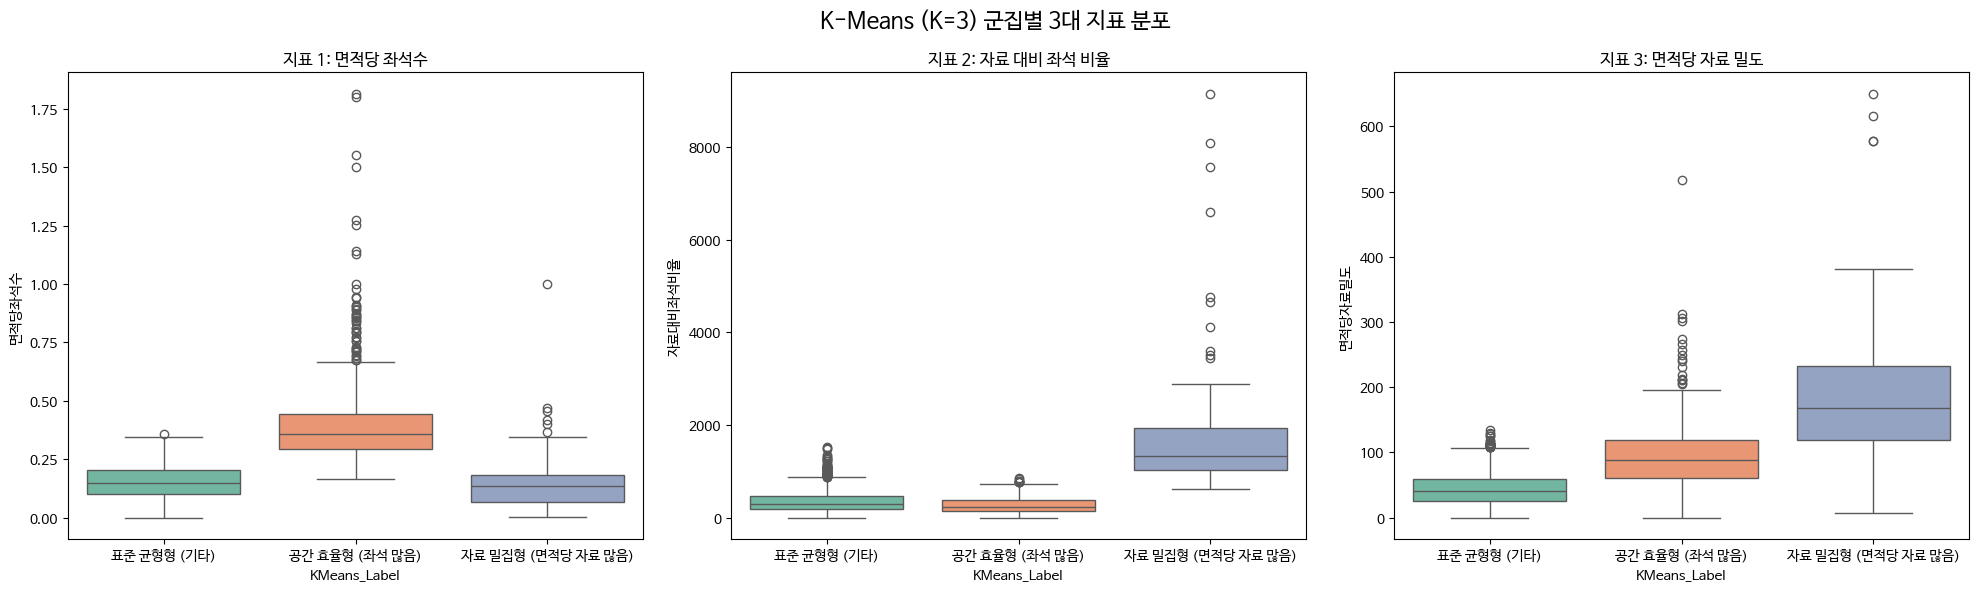


--- [군집별 관계 (Pairplot)] ---


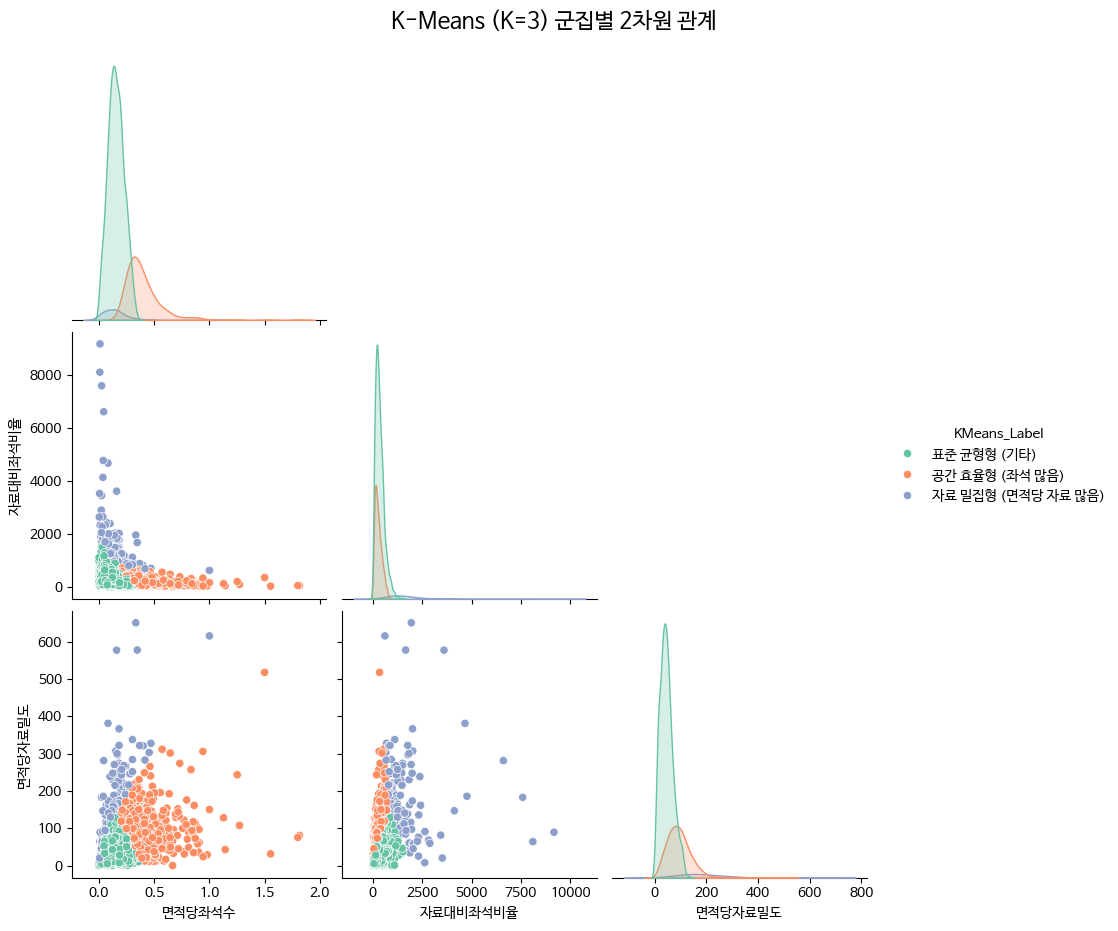

In [22]:
# --- 1. 시각화 도구 불러오기 ---
import seaborn as sns
import matplotlib.pyplot as plt

# 한글 폰트 설정
# (Windows 사용자는 'Malgun Gothic', Colab/Linux는 'NanumBarunGothic' 등을 사용)
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# [수정 1] K=3으로 제목 변경
print("--- [분석 2: K-Means (K=3)] 유형별 특성(평균값) ---")
print(cluster_profile) # 앞 단계에서 계산된 K=3 기준 평균값


# --- 2. 이름 붙이기 (Labeling) ---
# [수정 2] K=3에 맞게 로직 수정
# 자동으로 특징이 가장 강한 그룹에 이름을 붙여봅니다.
# (주의: 만약 한 그룹이 두 가지 지표 모두 1등이라면 이름이 덮어씌워질 수 있으니 결과 확인 필요)

labels_dict = {}

# 각 지표별로 가장 높은 값을 가진 그룹 찾기
max_seat_group = cluster_profile['면적당좌석수'].idxmax()
max_ratio_group = cluster_profile['자료대비좌석비율'].idxmax()
max_density_group = cluster_profile['면적당자료밀도'].idxmax()

# 이름 할당
labels_dict[max_seat_group] = '공간 효율형 (좌석 많음)'
labels_dict[max_ratio_group] = '자료 중심형 (자료 비율 높음)'
labels_dict[max_density_group] = '자료 밀집형 (면적당 자료 많음)'

# [수정 3] 이름이 안 붙은 나머지 그룹 처리 (K=3 기준)
all_indices = set(range(3)) # 0, 1, 2
assigned_indices = set(labels_dict.keys())
remaining_indices = all_indices - assigned_indices

for idx in remaining_indices:
    labels_dict[idx] = '표준 균형형 (기타)'

print("\n--- [자동 생성된 이름] ---")
print(labels_dict)

# 데이터프레임에 이름 적용
df_analysis['KMeans_Label'] = df_analysis['KMeans_Cluster'].map(labels_dict)


# --- 3. 군집별 특성 분포 시각화 (Boxplot) ---
print("\n--- [군집별 특성 분포 (Boxplot)] ---")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('K-Means (K=3) 군집별 3대 지표 분포', fontsize=16)

features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']

# 지표 1: 면적당좌석수
sns.boxplot(ax=axes[0], data=df_analysis, x='KMeans_Label', y=features[0], palette='Set2')
axes[0].set_title('지표 1: 면적당 좌석수')

# 지표 2: 자료대비좌석비율
sns.boxplot(ax=axes[1], data=df_analysis, x='KMeans_Label', y=features[1], palette='Set2')
axes[1].set_title('지표 2: 자료 대비 좌석 비율')

# 지표 3: 면적당자료밀도
sns.boxplot(ax=axes[2], data=df_analysis, x='KMeans_Label', y=features[2], palette='Set2')
axes[2].set_title('지표 3: 면적당 자료 밀도')

plt.tight_layout()
plt.show()


# --- 4. 군집별 관계 시각화 (Pairplot) ---
print("\n--- [군집별 관계 (Pairplot)] ---")
pair_plot = sns.pairplot(df_analysis, hue='KMeans_Label', vars=features,
                         corner=True, height=3, palette='Set2')
pair_plot.fig.suptitle('K-Means (K=3) 군집별 2차원 관계', y=1.03, fontsize=16)
plt.show()

--- [HDBSCAN '독자 운영형' 시각화] ---
독자 운영형 도서관 수: 102개

--- [시각화 3: '독자 운영형' 분포 (Pairplot)] ---
독자 운영형(주황색)이 표준 유형(파란색)과 비교해 어디에 분포하는지 확인합니다.


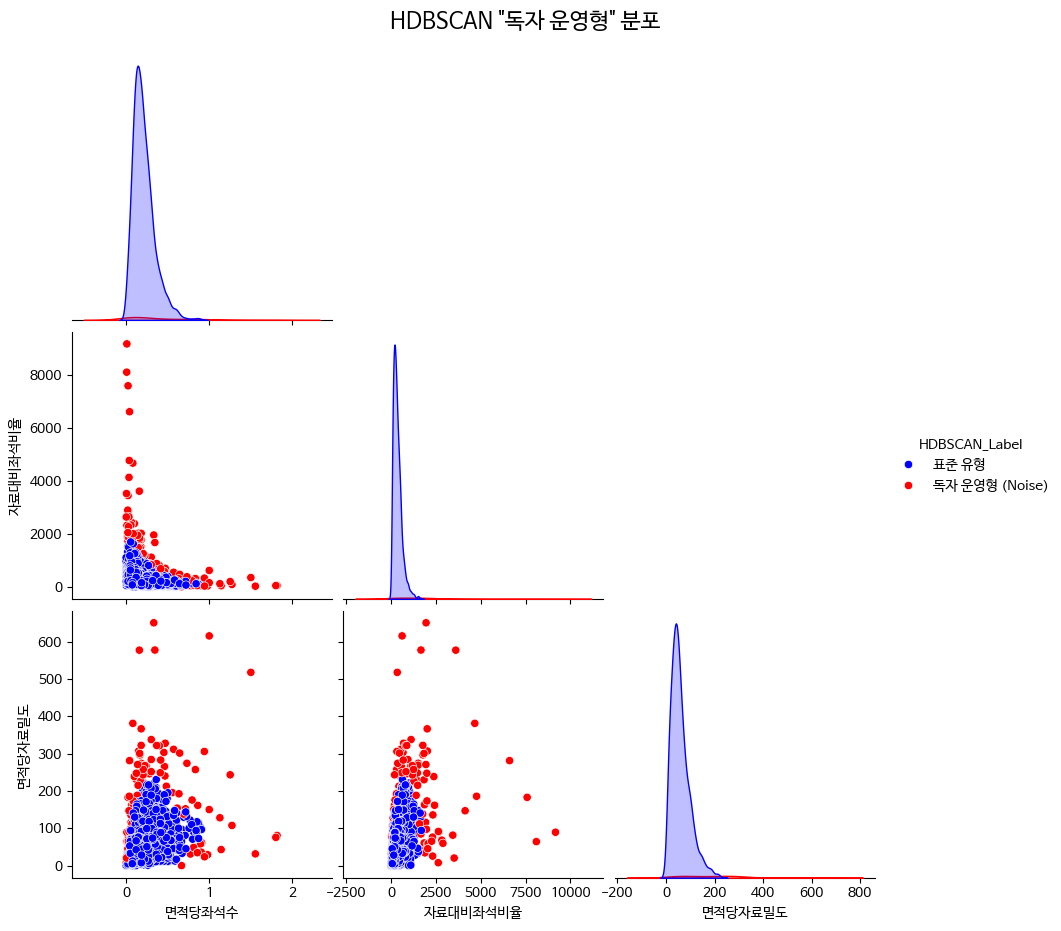

In [11]:
print("--- [HDBSCAN '독자 운영형' 시각화] ---")
# 6단계에서 계산한 HDBSCAN_Cluster 열을 사용합니다.
# -1 이면 "독자 운영형", 그 외(0, 1, 2...)는 "표준 유형"으로 라벨을 만듭니다.

# np.where는 엑셀의 IF함수와 같습니다.
# (조건, "참일때 값", "거짓일때 값")
df_analysis['HDBSCAN_Label'] = np.where(df_analysis['HDBSCAN_Cluster'] == -1,
                                        '독자 운영형 (Noise)',
                                        '표준 유형')

print(f"독자 운영형 도서관 수: {(df_analysis['HDBSCAN_Label'] == '독자 운영형 (Noise)').sum()}개")

# --- Pairplot 시각화 (HDBSCAN 기준) ---
print("\n--- [시각화 3: '독자 운영형' 분포 (Pairplot)] ---")
print("독자 운영형(주황색)이 표준 유형(파란색)과 비교해 어디에 분포하는지 확인합니다.")

hdb_plot = sns.pairplot(df_analysis, hue='HDBSCAN_Label', vars=features,
                        corner=True, height=3,
                        palette={'표준 유형': 'blue', '독자 운영형 (Noise)': 'red'}) # 색상 지정
hdb_plot.fig.suptitle('HDBSCAN "독자 운영형" 분포', y=1.03, fontsize=16)
plt.show()

--- [GMM '복합 유형' 시각화] ---
복합 유형 도서관 수: 2790개

--- [시각화 4: '복합 유형' 분포 (Pairplot)] ---
'복합 유형'(주황색)이 '명확한 유형'(파란색) 그룹들 사이에 어떻게 분포하는지 확인합니다.


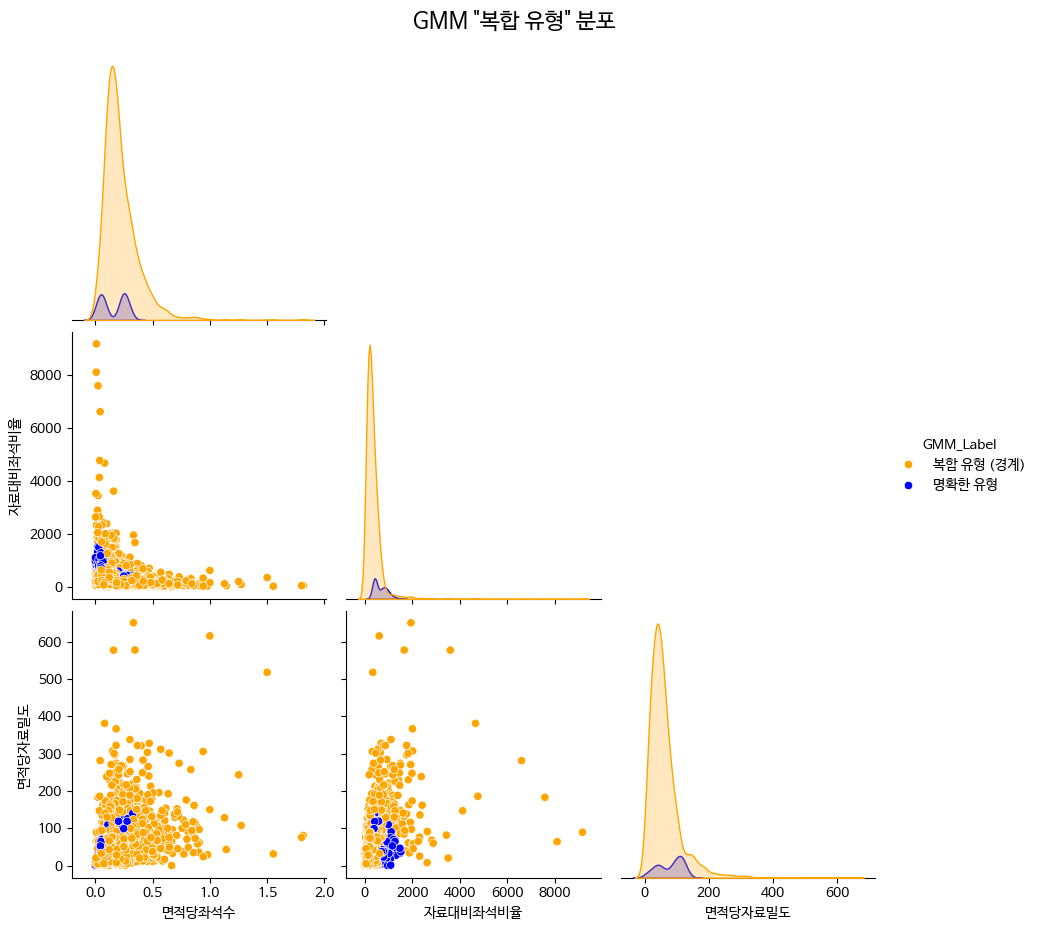

In [21]:
print("--- [GMM '복합 유형' 시각화] ---")
# 8단계에서 계산한 GMM 결과와 K-Means 결과를 비교합니다.

# "복합 유형" 조건 (8단계와 동일) [cite: 1812]
hybrid_condition = (df_analysis['KMeans_Cluster'] != df_analysis['GMM_Cluster']) | \
                   (df_analysis['GMM_Max_Prob'] < 0.8)

# IF함수로 "복합 유형" 라벨 생성
df_analysis['GMM_Label'] = np.where(hybrid_condition,
                                  '복합 유형 (경계)',
                                  '명확한 유형')

print(f"복합 유형 도서관 수: {(df_analysis['GMM_Label'] == '복합 유형 (경계)').sum()}개")

# --- Pairplot 시각화 (GMM 기준) ---
print("\n--- [시각화 4: '복합 유형' 분포 (Pairplot)] ---")
print("'복합 유형'(주황색)이 '명확한 유형'(파란색) 그룹들 사이에 어떻게 분포하는지 확인합니다.")

gmm_plot = sns.pairplot(df_analysis, hue='GMM_Label', vars=features,
                        corner=True, height=3,
                        palette={'명확한 유형': 'blue', '복합 유형 (경계)': 'orange'}) # 색상 지정
gmm_plot.fig.suptitle('GMM "복합 유형" 분포', y=1.03, fontsize=16)
plt.show()

In [14]:
import plotly.express as px

# [수정 1] 원본 데이터(df)에서 '도서관명'을 가져와 df_analysis에 추가합니다.
# (인덱스가 일치하는 행끼리 자동으로 매칭됩니다)
if '도서관명' not in df_analysis.columns:
    df_analysis['도서관명'] = df.loc[df_analysis.index, '도서관명']

print("--- [ K-Means 3D (작은 점)] ---")
# features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']

fig_kmeans = px.scatter_3d(
    df_analysis,
    x=features[0],          # x축
    y=features[1],          # y축
    z=features[2],          # z축
    color='KMeans_Label',   # 우리가 붙인 이름(유형)별로 색상 지정
    hover_data=['도서관명'], # 이제 '도서관명'이 있으므로 에러가 나지 않습니다.
    title='[K-Means] 3대 표준 유형 3D 시각화 (작은 점)' # [수정 2] 4대 -> 3대 변경
)

# --- [수정된 부분] ---
# 모든 점(trace)의 마커(marker) 크기(size)를 2로 설정합니다.
fig_kmeans.update_traces(marker=dict(size=2))
# (숫자를 1 ~ 3 정도로 조절해 보세요.)
# --------------------

fig_kmeans.show() # Colab에서 인터랙티브 그래프 출력

--- [ K-Means 3D (작은 점)] ---


In [19]:
import plotly.express as px

# [안전장치] 만약 앞 단계에서 '도서관명'을 추가하지 않았다면, 여기서 추가합니다.
if '도서관명' not in df_analysis.columns:
    df_analysis['도서관명'] = df.loc[df_analysis.index, '도서관명']

# ---------------------------------------------------------
# 1. HDBSCAN 3D 시각화
# ---------------------------------------------------------
print("--- [ HDBSCAN 3D (작은 점)] ---")

fig_hdb = px.scatter_3d(
    df_analysis,
    x=features[0],
    y=features[1],
    z=features[2],
    color='HDBSCAN_Label', # "독자 운영형" vs "표준 유형"
    hover_data=['도서관명'], # 마우스를 올리면 도서관 이름 표시
    title='[HDBSCAN] "독자 운영형" 3D 시각화 (작은 점)',
    color_discrete_map={'표준 유형': 'blue', '독자 운영형 (Noise)': 'red'}
)

# 점 크기 조절 (작게)
fig_hdb.update_traces(marker=dict(size=2))
fig_hdb.show()

--- [ HDBSCAN 3D (작은 점)] ---


In [20]:
import plotly.express as px

# [안전장치] 만약 앞 단계에서 '도서관명'을 추가하지 않았다면, 여기서 추가합니다.
if '도서관명' not in df_analysis.columns:
    df_analysis['도서관명'] = df.loc[df_analysis.index, '도서관명']

# ---------------------------------------------------------
# 2. GMM 3D 시각화
# ---------------------------------------------------------
print("--- [ GMM 3D (작은 점)] ---")

fig_gmm = px.scatter_3d(
    df_analysis,
    x=features[0],
    y=features[1],
    z=features[2],
    color='GMM_Label', # "복합 유형" vs "명확한 유형"
    hover_data=['도서관명'],
    title='[GMM] "복합 유형" 3D 시각화 (작은 점)',
    color_discrete_map={'명확한 유형': 'blue', '복합 유형 (경계)': 'orange'}
)

# 점 크기 조절 (작게)
fig_gmm.update_traces(marker=dict(size=2))
fig_gmm.show()

--- [ GMM 3D (작은 점)] ---


In [18]:
import plotly.graph_objects as go
import pandas as pd

print("--- [ K-Means 유형별 프로필 (레이더 차트)] ---")

# --- 1. 시각화를 위한 데이터 준비 ---
features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']

# 'data_scaled'(표준화된 데이터)를 데이터프레임으로 변환
df_scaled_features = pd.DataFrame(data_scaled,
                                  columns=[f"{col}_scaled" for col in features],
                                  index=df_analysis.index)

# [안전장치] 이미 스케일링 된 컬럼이 있다면 삭제 후 다시 병합 (중복 방지)
cols_to_remove = [col for col in df_scaled_features.columns if col in df_analysis.columns]
df_analysis = df_analysis.drop(columns=cols_to_remove)

# 원본 데이터프레임 옆에 스케일링 된 데이터 붙이기
df_analysis_scaled = pd.concat([df_analysis, df_scaled_features], axis=1)

# K-Means 라벨별로 '표준화된 값'의 평균 계산
scaled_features_names = [f"{col}_scaled" for col in features]
profile_scaled = df_analysis_scaled.groupby('KMeans_Label')[scaled_features_names].mean()

# --- 2. 레이더 차트 그리기 ---
fig_radar = go.Figure()

for label in profile_scaled.index:
    values = profile_scaled.loc[label].values

    fig_radar.add_trace(go.Scatterpolar(
        r=values,             # 값 (표준화된 평균 Z-Score)
        theta=features,       # 축 (3대 지표 이름)
        fill='toself',        # 도형 안쪽 색칠하기
        name=label            # 범례 이름 (예: 자료 중심형)
    ))

# --- 3. 차트 꾸미기 ---
fig_radar.update_layout(
  title='[K-Means] 3대 표준 유형 프로필 (레이더 차트)', # [수정] 4대 -> 3대
  polar=dict(
    radialaxis=dict(
      visible=True,
      # [수정] 범위를 고정하지 않고 자동 조절되도록 주석 처리했습니다.
      # 값이 2.5를 넘어가는 강력한 특징이 있을 수 있기 때문입니다.
      # range=[-1.5, 2.5]
    )),
  showlegend=True
)

fig_radar.show()

--- [ K-Means 유형별 프로필 (레이더 차트)] ---


In [23]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

print("--- [HDBSCAN 유형별 프로필 (레이더 차트)] ---")

# --- 0. (안전장치) 필수 변수 및 데이터 확인 ---
features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']

# df_analysis_scaled가 없다면 다시 만듭니다.
if 'df_analysis_scaled' not in locals():
    # 스케일링 된 데이터 프레임 생성
    df_scaled_features = pd.DataFrame(data_scaled,
                                      columns=[f"{col}_scaled" for col in features],
                                      index=df_analysis.index)

    # 중복 컬럼 제거 후 병합
    cols_to_remove = [col for col in df_scaled_features.columns if col in df_analysis.columns]
    df_analysis_temp = df_analysis.drop(columns=cols_to_remove)
    df_analysis_scaled = pd.concat([df_analysis_temp, df_scaled_features], axis=1)

# HDBSCAN_Label이 잘 들어있는지 확인
if 'HDBSCAN_Label' not in df_analysis_scaled.columns:
    # 만약 없다면 df_analysis에서 가져오거나 다시 생성
    if 'HDBSCAN_Label' in df_analysis.columns:
        df_analysis_scaled['HDBSCAN_Label'] = df_analysis['HDBSCAN_Label']
    else:
        # 라벨이 아예 없으면 다시 생성 (HDBSCAN_Cluster 기준)
        df_analysis_scaled['HDBSCAN_Label'] = np.where(df_analysis['HDBSCAN_Cluster'] == -1,
                                                       '독자 운영형 (Noise)', '표준 유형')


# --- 1. 시각화를 위한 데이터 준비 ---
scaled_features_names = [f"{col}_scaled" for col in features]

# 'HDBSCAN_Label'별 평균 계산
profile_hdb = df_analysis_scaled.groupby('HDBSCAN_Label')[scaled_features_names].mean()

print("HDBSCAN 유형별 특성(표준화 평균값):")
print(profile_hdb)

# --- 2. 레이더 차트 그리기 ---
fig_radar_hdb = go.Figure()

# 색상 지정 (표준: 파랑, 독자운영: 빨강)
colors = {'표준 유형': 'blue', '독자 운영형 (Noise)': 'red'}

for label in profile_hdb.index:
    values = profile_hdb.loc[label].values
    color = colors.get(label, 'grey') # 지정된 색이 없으면 회색

    fig_radar_hdb.add_trace(go.Scatterpolar(
        r=values,             # 값
        theta=features,       # 축 이름
        fill='toself',        # 채우기
        name=label,           # 범례 이름
        line_color=color      # 선 색상
    ))

# --- 3. 차트 꾸미기 ---
fig_radar_hdb.update_layout(
  title='[HDBSCAN] "독자 운영형" vs "표준 유형" 프로필 비교',
  polar=dict(
    radialaxis=dict(
      visible=True,
      # range=[-1, 5] # 필요시 주석 해제하여 범위 고정 가능
    )),
  showlegend=True
)

fig_radar_hdb.show()

--- [HDBSCAN 유형별 프로필 (레이더 차트)] ---
HDBSCAN 유형별 특성(표준화 평균값):
                면적당좌석수_scaled  자료대비좌석비율_scaled  면적당자료밀도_scaled
HDBSCAN_Label                                                 
독자 운영형 (Noise)       1.230670         2.649786        2.517681
표준 유형               -0.042668        -0.091869       -0.087289


In [24]:
import plotly.graph_objects as go
import pandas as pd

print("--- [GMM 유형별 프로필 (레이더 차트)] ---")

# --- 0. (안전장치) 필수 변수 및 데이터 확인 ---
features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']

# 1. df_analysis_scaled가 메모리에 있는지 확인하고 없으면 다시 만듭니다.
if 'df_analysis_scaled' not in locals():
    # 스케일링 된 데이터 프레임 생성
    df_scaled_features = pd.DataFrame(data_scaled,
                                      columns=[f"{col}_scaled" for col in features],
                                      index=df_analysis.index)

    # 중복 컬럼 제거 후 병합
    cols_to_remove = [col for col in df_scaled_features.columns if col in df_analysis.columns]
    df_analysis_temp = df_analysis.drop(columns=cols_to_remove)
    df_analysis_scaled = pd.concat([df_analysis_temp, df_scaled_features], axis=1)

# 2. 'GMM_Label'이 잘 들어있는지 확인 (없으면 df_analysis에서 가져옴)
if 'GMM_Label' not in df_analysis_scaled.columns:
    df_analysis_scaled['GMM_Label'] = df_analysis['GMM_Label']


# --- 1. 시각화를 위한 데이터 준비 ---
scaled_features_names = [f"{col}_scaled" for col in features]
categories = features # 3대 지표 이름

# 'GMM_Label'별 평균 계산
profile_gmm = df_analysis_scaled.groupby('GMM_Label')[scaled_features_names].mean()

print("GMM 유형별 특성(표준화 평균값):")
print(profile_gmm)

# --- 2. 레이더 차트 그리기 ---
fig_radar_gmm = go.Figure()

# 색상 지정 (명확한 유형: 파랑, 복합 유형: 주황 - 3D 그래프와 깔맞춤)
colors = {'명확한 유형': 'blue', '복합 유형 (경계)': 'orange'}

for label in profile_gmm.index:
    values = profile_gmm.loc[label].values
    color = colors.get(label, 'grey') # 지정된 색이 없으면 회색

    fig_radar_gmm.add_trace(go.Scatterpolar(
        r=values,             # 값 (표준화된 평균)
        theta=categories,     # 축 (3대 지표)
        fill='toself',        # 영역 채우기
        name=label,           # 유형 이름
        line_color=color      # 선 색상 지정
    ))

# --- 3. 차트 꾸미기 ---
fig_radar_gmm.update_layout(
  title='[GMM] "복합 유형" vs "명확한 유형" 프로필 비교',
  polar=dict(
    radialaxis=dict(
      visible=True,
      # range=[-1, 3] # 필요시 주석 해제하여 범위 고정 가능
    )),
  showlegend=True # 범례 표시
)

fig_radar_gmm.show()

--- [GMM 유형별 프로필 (레이더 차트)] ---
GMM 유형별 특성(표준화 평균값):
            면적당좌석수_scaled  자료대비좌석비율_scaled  면적당자료밀도_scaled
GMM_Label                                                 
명확한 유형          -0.386188         0.638851        0.335396
복합 유형 (경계)       0.035158        -0.058161       -0.030534


--- [3-Way 모델 실루엣 계수 비교] ---
[K-Means] 실루엣 계수: 0.4179
[GMM]     실루엣 계수: 0.2357
[HDBSCAN] 실루엣 계수: 0.6124 (노이즈 제외)

(해석: 점수가 높을수록(1에 가까울수록) 군집화가 잘 된 것입니다.)


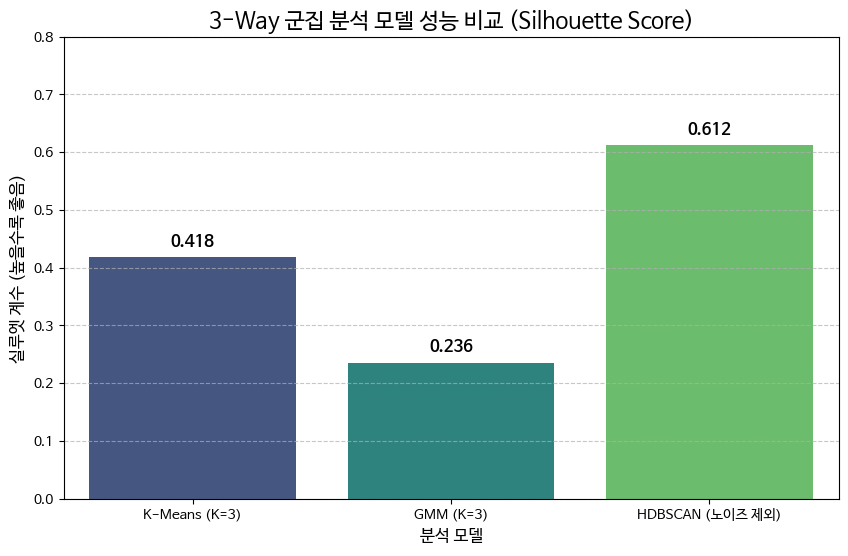

In [25]:
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("--- [3-Way 모델 실루엣 계수 비교] ---")

# --- 1. K-Means 실루엣 계수 ---
# 현재 메모리에 있는 라벨 사용 (K=3)
kmeans_labels = df_analysis['KMeans_Cluster']
score_kmeans = silhouette_score(data_scaled, kmeans_labels)

# --- 2. GMM 실루엣 계수 ---
gmm_labels = df_analysis['GMM_Cluster']
score_gmm = silhouette_score(data_scaled, gmm_labels)

# --- 3. HDBSCAN 실루엣 계수 (중요: 노이즈 제외) ---
# 노이즈(-1)는 군집이 아니므로 점수 계산에서 빼야 공정합니다.
hdbscan_labels_all = df_analysis['HDBSCAN_Cluster']

is_noise = (hdbscan_labels_all == -1)
data_scaled_hdb = data_scaled[~is_noise] # 노이즈가 아닌 데이터만 선택
labels_hdb = hdbscan_labels_all[~is_noise]

# 유효한 군집이 2개 이상일 때만 계산
if len(set(labels_hdb)) >= 2:
    score_hdb = silhouette_score(data_scaled_hdb, labels_hdb)
else:
    print("[HDBSCAN] 경고: 유효한 군집이 너무 적어 점수를 계산할 수 없습니다.")
    score_hdb = 0

# --- 4. 비교 결과 출력 ---
print(f"[K-Means] 실루엣 계수: {score_kmeans:.4f}")
print(f"[GMM]     실루엣 계수: {score_gmm:.4f}")
print(f"[HDBSCAN] 실루엣 계수: {score_hdb:.4f} (노이즈 제외)")
print("\n(해석: 점수가 높을수록(1에 가까울수록) 군집화가 잘 된 것입니다.)")

# --- 5. 막대그래프 시각화 ---
# [수정] 라벨 이름을 현재 상태(K=3)에 맞게 변경했습니다.
scores_data = {
    'Model': ['K-Means (K=3)', 'GMM (K=3)', 'HDBSCAN (노이즈 제외)'],
    'Score': [score_kmeans, score_gmm, score_hdb]
}
scores_df = pd.DataFrame(scores_data)

# 시각화 설정
plt.figure(figsize=(10, 6))
# palette='viridis'로 색상을 예쁘게 지정
sns.barplot(data=scores_df, x='Model', y='Score', palette='viridis')

# 각 막대 위에 점수 표시
for index, row in scores_df.iterrows():
    if not np.isnan(row['Score']):
        plt.text(index, row['Score'] + 0.02, f"{row['Score']:.3f}",
                 color='black', ha="center", fontsize=12, fontweight='bold')

plt.title('3-Way 군집 분석 모델 성능 비교 (Silhouette Score)', fontsize=16)
plt.xlabel('분석 모델', fontsize=12)
plt.ylabel('실루엣 계수 (높을수록 좋음)', fontsize=12)
plt.ylim(0, 0.8) # y축 범위를 적절히 조절 (최대 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7) # 가로 격자 추가
plt.show()

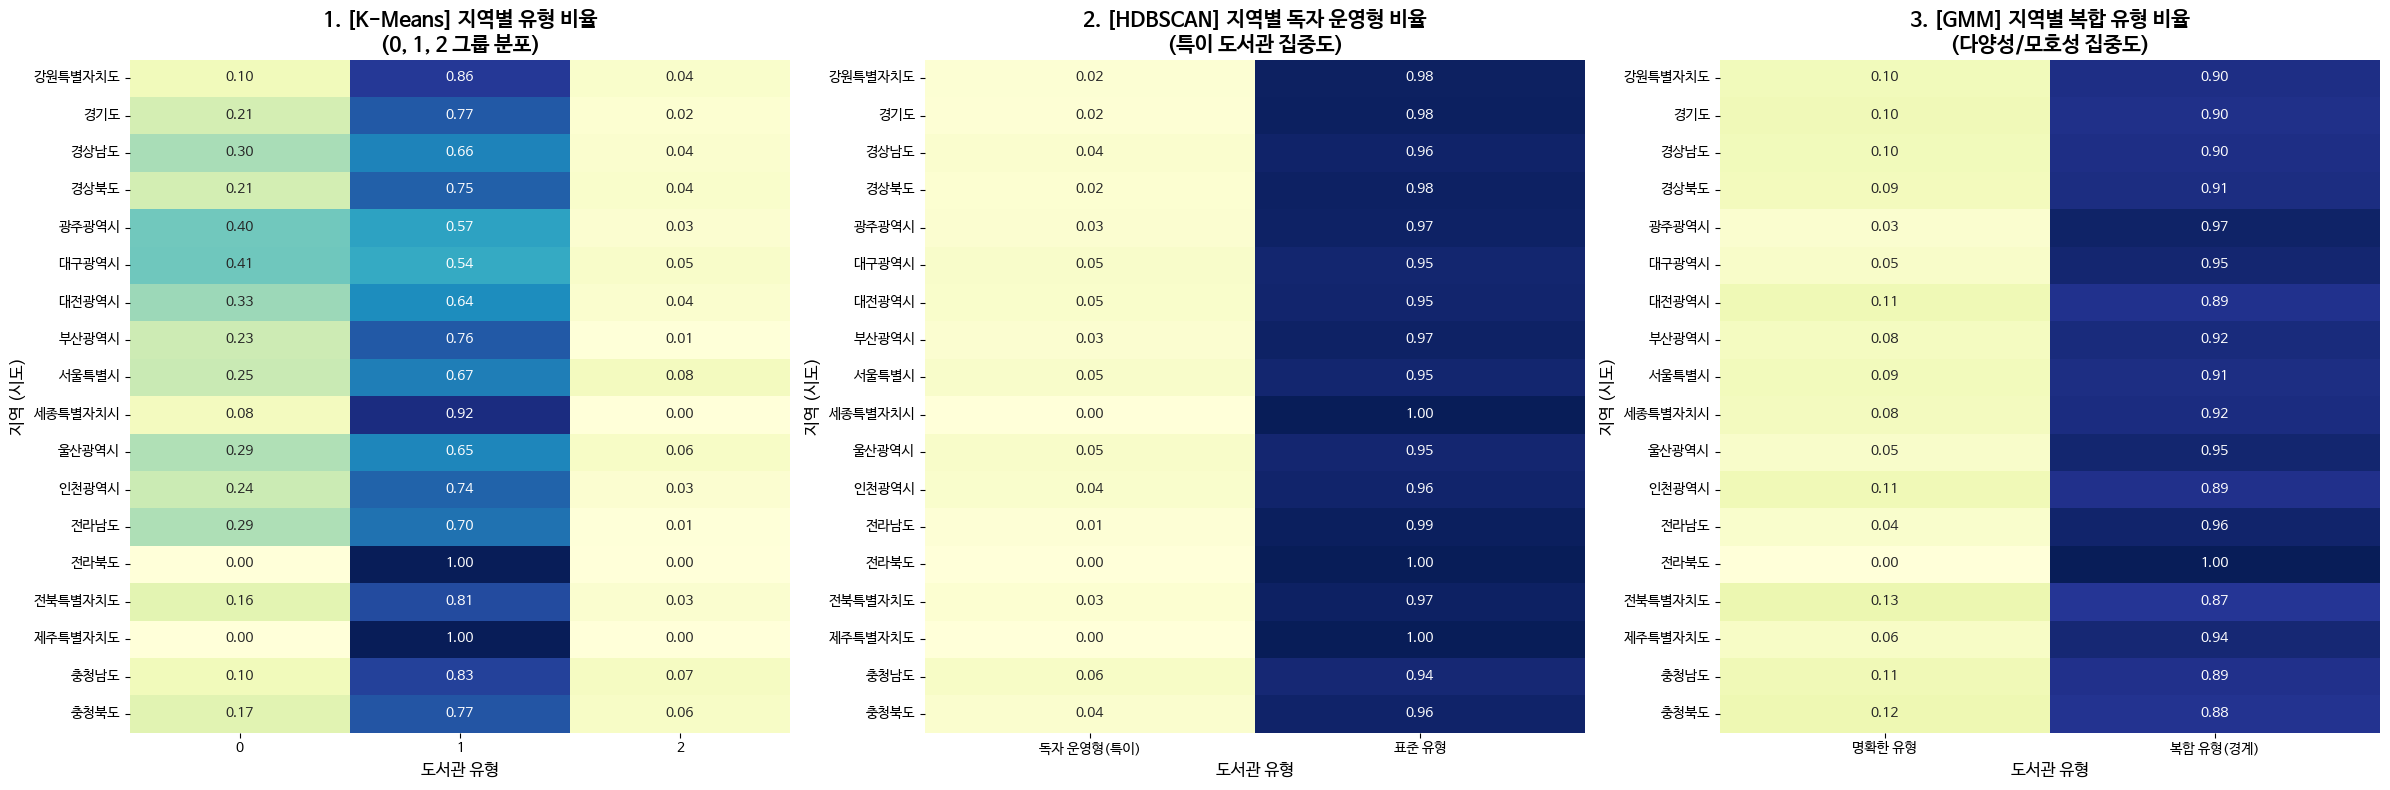


--- [분석 요약: 어떤 지역이 특징적인가?] ---

[HDBSCAN] '독자 운영형(특이)' 도서관 비율이 높은 지역 Top 3:
  - 충청남도: 6.0% (특색있는 도서관이 많음)
  - 울산광역시: 5.4% (특색있는 도서관이 많음)
  - 대구광역시: 4.9% (특색있는 도서관이 많음)

[GMM] '복합 유형(경계)' 도서관 비율이 높은 지역 Top 3:
  - 전라북도: 100.0% (성격이 복합적인 도서관이 많음)
  - 광주광역시: 96.5% (성격이 복합적인 도서관이 많음)
  - 전라남도: 96.0% (성격이 복합적인 도서관이 많음)


In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
# HDBSCAN이 없으면 DBSCAN으로 대체 (환경 호환성)
try:
    import hdbscan
except ImportError:
    from sklearn.cluster import DBSCAN

# --- 1. 데이터 준비 및 알고리즘 재실행 (모든 라벨 복구) ---
file_path = '/content/sample_data/(필요없는 데이터 삭제)도서관데이터.csv'
df = pd.read_csv(file_path)

# 지표 생성
df['총자료수'] = df['자료수(도서)'].fillna(0) + df['자료수(연속간행물)'].fillna(0) + df['자료수(비도서)'].fillna(0)
df['면적당좌석수'] = df['열람좌석수'] / df['건물면적']
df['자료대비좌석비율'] = df['총자료수'] / df['열람좌석수']
df['면적당자료밀도'] = df['총자료수'] / df['건물면적']

features = ['면적당좌석수', '자료대비좌석비율', '면적당자료밀도']
df_analysis = df[features].copy()
df_analysis['시도명'] = df['시도명'] # 지역 분석을 위해 시도명 추가
df_analysis.replace([np.inf, -np.inf], np.nan, inplace=True)
df_analysis.dropna(inplace=True)

# 스케일링
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_analysis[features])

# (1) K-Means (K=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_k = kmeans.fit_predict(data_scaled)
# 라벨링 (이전 분석 기반 단순화)
df_analysis['KMeans_Label'] = labels_k
# (실제로는 앞서 정의한 map 딕셔너리를 쓰면 더 좋지만, 여기선 0,1,2로 표현 후 해석)

# (2) HDBSCAN (Noise 탐지)
try:
    hdb = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5)
    labels_h = hdb.fit_predict(data_scaled)
except NameError: # hdbscan 모듈이 없으면 DBSCAN 사용
    db = DBSCAN(eps=0.5, min_samples=5)
    labels_h = db.fit_predict(data_scaled)

df_analysis['HDBSCAN_Label'] = np.where(labels_h == -1, '독자 운영형(특이)', '표준 유형')

# (3) GMM (복합 유형 탐지, K=3)
gmm = GaussianMixture(n_components=3, random_state=42)
labels_g = gmm.fit_predict(data_scaled)
probs_g = gmm.predict_proba(data_scaled).max(axis=1)

is_hybrid = (labels_k != labels_g) | (probs_g < 0.8)
df_analysis['GMM_Label'] = np.where(is_hybrid, '복합 유형(경계)', '명확한 유형')


# --- 2. 시각화: 지역별(시도명) 분포 히트맵 ---
# 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# 함수: 교차표(Cross-tab) 생성 및 히트맵 그리기
def draw_heatmap(ax, col_label, title):
    # 지역별로 해당 유형이 몇 개인지 셉니다.
    crosstab = pd.crosstab(df_analysis['시도명'], df_analysis[col_label])
    # 보기 좋게 정규화 (지역별 합계가 1이 되도록 -> 비율 비교)
    crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)

    sns.heatmap(crosstab_norm, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax, cbar=False)
    ax.set_title(title, fontsize=15, fontweight='bold')
    ax.set_ylabel('지역 (시도)', fontsize=12)
    ax.set_xlabel('도서관 유형', fontsize=12)

# (1) K-Means 분포
draw_heatmap(axes[0], 'KMeans_Label', '1. [K-Means] 지역별 유형 비율\n(0, 1, 2 그룹 분포)')

# (2) HDBSCAN 분포 (독자 운영형이 어디에 많은가?)
draw_heatmap(axes[1], 'HDBSCAN_Label', '2. [HDBSCAN] 지역별 독자 운영형 비율\n(특이 도서관 집중도)')

# (3) GMM 분포 (복합 유형이 어디에 많은가?)
draw_heatmap(axes[2], 'GMM_Label', '3. [GMM] 지역별 복합 유형 비율\n(다양성/모호성 집중도)')

plt.tight_layout()
plt.show()

# --- 3. 텍스트 요약 (어디가 "Top" 인가?) ---
print("\n--- [분석 요약: 어떤 지역이 특징적인가?] ---")

# 독자 운영형 비율이 가장 높은 지역 Top 3
hdb_ratio = pd.crosstab(df_analysis['시도명'], df_analysis['HDBSCAN_Label'], normalize='index')
if '독자 운영형(특이)' in hdb_ratio.columns:
    top_noise_regions = hdb_ratio['독자 운영형(특이)'].sort_values(ascending=False).head(3)
    print(f"\n[HDBSCAN] '독자 운영형(특이)' 도서관 비율이 높은 지역 Top 3:")
    for region, ratio in top_noise_regions.items():
        print(f"  - {region}: {ratio*100:.1f}% (특색있는 도서관이 많음)")

# 복합 유형 비율이 가장 높은 지역 Top 3
gmm_ratio = pd.crosstab(df_analysis['시도명'], df_analysis['GMM_Label'], normalize='index')
if '복합 유형(경계)' in gmm_ratio.columns:
    top_hybrid_regions = gmm_ratio['복합 유형(경계)'].sort_values(ascending=False).head(3)
    print(f"\n[GMM] '복합 유형(경계)' 도서관 비율이 높은 지역 Top 3:")
    for region, ratio in top_hybrid_regions.items():
        print(f"  - {region}: {ratio*100:.1f}% (성격이 복합적인 도서관이 많음)")